<a href="https://colab.research.google.com/github/hojun0705/DeepSpeech/blob/master/BERT_Pytorch_TxtClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print('Got ya GPU! at :{}'.format(device_name))

else: 
  raise SystemError('GPU device not found!!!')

Got ya GPU! at :/device:GPU:0


In [64]:
import torch
if torch.cuda.is_available():

  device = torch.device('cuda')

  print('there are %d GPU(s) available!!!!' % torch.cuda.device_count())
  print('We will use the GPU(s)', torch.cuda.get_device_name(0))


#if not.......................?
else:
  print('No GPU! Let us hire interns to manually calculate')
  device = tourch.device('cpu')

there are 1 GPU(s) available!!!!
We will use the GPU(s) Tesla P100-PCIE-16GB


In [2]:
import urllib
import os

# creat the data dir

if not os.path.exists('./data/'):
  os.mkdir('./data/')

files = [
         ('./data/attack_annotated_comments.tsv', 'https://ndownloader.figshare.com/files/7554634'),
         ('./data/attack_annotations.tsv', 'https://ndownloader.figshare.com/files/7554637')
]

for (filename, url) in files:

  if not os.path.exists(filename):

    urllib.request.urlretrieve(url, filename)

    print(' DONE SUCKER!')


 DONE SUCKER!
 DONE SUCKER!


In [3]:
import pandas as pd

comments = pd.read_csv('./data/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('./data/attack_annotations.tsv', sep = '\t')

print('DONE SUCKERS AGAIN!')

DONE SUCKERS AGAIN!


In [4]:
comments.head

<bound method NDFrame.head of                                                      comment  ...  split
rev_id                                                        ...       
37675      `-NEWLINE_TOKENThis is not ``creative``.  Thos...  ...  train
44816      `NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...  ...  train
49851      NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...  ...  train
89320       Next, maybe you could work on being less cond...  ...    dev
93890                   This page will need disambiguation.   ...  train
...                                                      ...  ...    ...
699848324  `NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThese ...  ...  train
699851288  NEWLINE_TOKENNEWLINE_TOKENThe Institute for Hi...  ...   test
699857133  NEWLINE_TOKEN:The way you're trying to describ...  ...  train
699891012  NEWLINE_TOKENNEWLINE_TOKEN== Warning ==NEWLINE...  ...    dev
699897151  Alternate option===NEWLINE_TOKENIs there perha...  ...  train

[115864 rows x 6 col

In [5]:
comments[['comment','split']].groupby('split').count()

,comment
split,
dev,23160
test,23178
train,69526


In [6]:
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [0]:
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [8]:
labels

rev_id
37675        False
44816        False
49851        False
89320        False
93890        False
             ...  
699848324    False
699851288    False
699857133    False
699891012    False
699897151    False
Name: attack, Length: 115864, dtype: bool

In [0]:
#join label and comments
comments['attack'] = labels

In [0]:
#remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace('NEWLINE_TOKEN', ' '))
comments['comment'] = comments['comment'].apply(lambda x: x.replace('TAB_TOKEN', ' '))

In [0]:
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

In [12]:
import textwrap
import random


#wrap text to 80 chars

wrapper = textwrap.TextWrapper(width=80)

# filter to just the 'attack' comments.

attack_examples = train_comments.query('attack')['comment']

for i in range(10):

  j = random.choice(attack_examples.index)

  print('')
  print(wrapper.fill(attack_examples[j]))
  print('')


 The only nonsense I will approve is nonsense committed by 1)chaka zulu
warriors. 2)anglican gay priests 3)cocksuck ers


`  == Yeah ==  You're right, he's a complete cock. Runs and tells his boyfriend
whenever anyone questions the shitty job he does of ``creating`` pages.`


  FUCK YOU ALKIVA wikipedia is a democracy, a work of contributors, IT IS NOT
ABOUT ELITISM, YOU DON'T OWN PAGES HERE.


`  == Fuck you. ==  {| style=``background-color: #fdffe7; border: 1px solid
#fceb92;`` |rowspan=``2`` style=``vertical-align: middle; padding: 5px;`` |
|style=``font-size: x-large; padding: 3px 3px 0 3px; height: 1.5em;`` | How dare
you? |- |style=``vertical-align: middle; padding: 3px;`` | I am studying history
at a top university and you have the nerve to tell me that I made that stuff up?
Fuck you.    |}`


  == Dude ==  Why do you fucking delete my shit when I didn't fucking do
anything to you retard!


` :::::::::Kind of completely backwards, given that this is one place I would
insult you

#**what percentage of the comments are attacks?** 

In [13]:
total_comments = len(comments)
num_attacks = len(comments.query('attack'))

print('{:,} of {:,} comments are attacks ({:.2%})'.format(num_attacks, total_comments, num_attacks/total_comments))

13,590 of 115,864 comments are attacks (11.73%)


# **Classes are very imbalanced, so we carefully interpret our accuracy**

In [14]:
prcnt_non_attack = 1 - (len(test_comments.query('attack'))/ len(test_comments))

print('predicting "not attack" will yield {:.2%} accuracy on the test set.'.format(prcnt_non_attack) )

predicting "not attack" will yield 88.11% accuracy on the test set.


# **Examples of 512 token limitations**

In [15]:
!pip install transformers

     |████████████████████████████████| 675kB 8.3MB/s 
     |████████████████████████████████| 890kB 22.6MB/s 
     |████████████████████████████████| 3.8MB 42.0MB/s 
     |████████████████████████████████| 1.1MB 53.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ab8af5e70e16c43fc78d08a26e0e0fb56a91de4cc79e0c1f85454c778886fd9b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [16]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [17]:
text = train_comments.iloc[0].comment

#run tokenizer to count up the numer of tokens.
tokens = tokenizer.tokenize(text)

print('comment 0 (not an attack contations {:,} WordPiece tokens.'.format(len(tokens)))

print(wrapper.fill(text))

comment 0 (not an attack contations 591 WordPiece tokens.
`- This is not ``creative``.  Those are the dictionary definitions of the terms
``insurance`` and ``ensurance`` as properly applied to ``destruction``.  If you
don't understand that, fine, legitimate criticism, I'll write up ``three man
cell`` and ``bounty hunter`` and then it will be easy to understand why
``ensured`` and ``insured`` are different - and why both differ from
``assured``.  The sentence you quote is absolutely neutral.  You just aren't
familiar with the underlying theory of strike-back (e.g. submarines as employed
in nuclear warfare) guiding the insurance, nor likely the three man cell
structure that kept the IRA from being broken by the British.  If that's my
fault, fine, I can fix that to explain.  But ther'es nothing ``personal`` or
``creative`` about it.  I'm tired of arguing with you.  Re: the other article,
``multi-party`` turns up plenty, and there is more use of ``mutually`` than
``mutual``.  If I were to 

In [18]:
#print out by tokens (surprisingly a few subwords)

print('=== first 512 tokens: === \n')
print(wrapper.fill(str(' '.join(tokens[0:512]))))

print('')

print('\n=== remaining {:,} tokens: ==== \n'.format(len(tokens) - 512))
print(wrapper.fill(str(' '.join(tokens[512:]))))

=== first 512 tokens: === 

` - this is not ` ` creative ` ` . those are the dictionary definitions of the
terms ` ` insurance ` ` and ` ` en ##sur ##ance ` ` as properly applied to ` `
destruction ` ` . if you don ' t understand that , fine , legitimate criticism ,
i ' ll write up ` ` three man cell ` ` and ` ` bounty hunter ` ` and then it
will be easy to understand why ` ` ensured ` ` and ` ` ins ##ured ` ` are
different - and why both differ from ` ` assured ` ` . the sentence you quote is
absolutely neutral . you just aren ' t familiar with the underlying theory of
strike - back ( e . g . submarines as employed in nuclear warfare ) guiding the
insurance , nor likely the three man cell structure that kept the ira from being
broken by the british . if that ' s my fault , fine , i can fix that to explain
. but the ##r ' es nothing ` ` personal ` ` or ` ` creative ` ` about it . i ' m
tired of arguing with you . re : the other article , ` ` multi - party ` ` turns
up plenty , and ther

# **Checking those tokens in words and sentences**

In [19]:
last_char = text.find('are made in')   


text = text[0:last_char]


#removing double spaces
text = text.replace('  ', ' ')
num_words = len(text.split(' '))

print('comments contains ~{:,} words.'.format(num_words))

num_sens = text.count('. ')

print('comments contains ~{:,} sentences.'.format(num_sens))

comments contains ~330 words.
comments contains ~20 sentences.


# **Tokennize all comments**


the tokenizer.encode function combines multiple steps for us

1. split the sentence into tokens
2. add the special [CLS] and [SEP] 
3. map the tokens to teir IDs


In [0]:
import numpy as np

input_ids = []

lengths = []


#for every sentence..
for sen in train_comments.comment:

  # report progress
  if ((len(input_ids) % 20000) == 0):
    print(' Read {:,} comments.'.format(len(input_ids)))

  encoded_sent = tokenizer.encode(
      sen,  #sentence to encode
      add_special_tokens = True, #[CLS] [SEP]
      #max_length = 512, 
      #return_tensors = 'pt
  )

  input_ids.append(encoded_sent)
  lengths.append(len(encoded_sent))

In [21]:
len(input_ids)

69526

In [22]:
len(train_comments)

69526

In [23]:
#retrieve the labels as a list

labels = train_comments.attack.to_numpy().astype(int)

print('{:>7,} positive with attack'.format(np.sum(labels)))
print('{:>7,} negaitive without attack'.format(len(labels) - np.sum(labels)))

  8,079 positive with attack
 61,447 negaitive without attack


In [24]:
#checking lengths of each data row

print('Min length: {:,} tokens.'.format(min(lengths)))
print('Max length: {:} tokens.'.format(max(lengths)))
print('Median length: {:} tokens.'.format(np.median(lengths)))

Min length: 2 tokens.
Max length: 9861 tokens.
Median length: 52.0 tokens.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


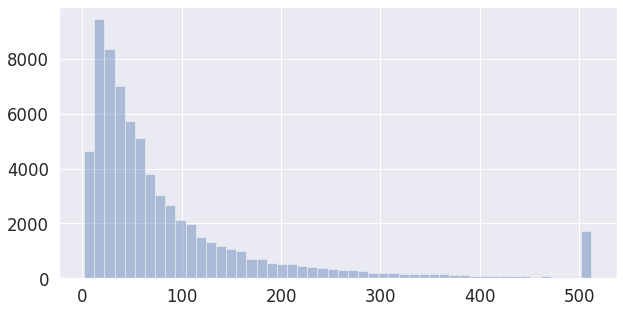

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

#increase plot and font size

sns.set(font_scale= 1.5)
plt.rcParams["figure.figsize"] = (10,5)

#truncate any comments lengths great than 512

lengths = [min(l, 512) for l in lengths]

#plot the distribution of comment lengths.


sns.distplot(lengths, kde = False, rug= False)

In [26]:
#counting what is bigger than 512 
num_truncated = lengths.count(512)

#comparing this to the total number of training sentences
num_sentences = len(lengths)

prcnt = float(num_truncated) / float(num_sentences)

print(' {:} of {:} sentences ({:.1%}) in the traiing set are longer than 512 tokens'.format(num_truncated, num_sentences, prcnt))

 1668 of 69526 sentences (2.4%) in the traiing set are longer than 512 tokens


# **How many contains attacks?**

In [27]:
num_positive = 0 
num_negative = 0

for i, l in enumerate(lengths):

  if l == 512:

    if labels[l] == 1:
      num_positive += 1
    else:
      num_negative += 1



print('{:} ({:.1%}) of the truncated examples contain a personal attack.'.format(num_positive, num_positive / (num_positive + num_negative)))

0 (0.0%) of the truncated examples contain a personal attack.


In [28]:
from keras.preprocessing.sequence import pad_sequences

#we further truncate to 128 bcuz if it is 516, that is really really expensive to compute

max_len = 128


#pad out input tokens with value 0 
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype = 'long',
                          value = 0, truncating = 'post', padding = 'post' )

Using TensorFlow backend.


In [0]:
#attention masks (spliting real string and padding) 0 for padding >0 for real token and assign value 1 for it

attention_masks = []

for sent in input_ids:

  att_mask = [int(token_id > 0) for token_id in sent]

  attention_masks.append(att_mask)

# **Final data preparation**

In [0]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2020,test_size = 0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state = 2020, test_size = 0.2)

# **Modeling by Pytorch**

In [0]:
import torch

In [0]:
#convert all inputs and labels into torch tensor.

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# **Making data pipeline**

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32


#create DataLoader

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size )

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

In [35]:
#taking huggingface bert fine tuning for classification

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False, #whether the model returns attentions weights.
    output_hidden_states = False, #whether the model returens all hidden states.
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
#Optimizer and Scheduler

optimizer = AdamW(model.parameters(), #parameters calls for anything that has to be optimized with parametric form
                  lr = 2e-5,
                  eps = 1e-8
                  )



In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 4


#total number of training steps is number of batches * number of epochs
total_steps = len(train_dataloader) * epochs


#create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, #defualt value
                                            num_training_steps = total_steps)


In [0]:
#accuracy function

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis = 1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):

  elapsed_rouneded = int(round((elapsed)))

  return str(datetime.timedelta(seconds=elapsed_rouneded))

# **Training**

In [69]:
#trainig

import random


seed_val = 2020

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


#store average loss here
loss_values = []



for epoch_i in range(0, epochs):

  print('')
  print('======epoch {:} / {:} ======='.format(epoch_i +1 , epochs))
  print('Training...')

  #measuring time of now
  t0 = time.time()

  #reset total loss for this epoch
  total_loss = 0


  #putting model into training mode 
  model.train()


  for step, batch in enumerate(train_dataloader):


    #progress update every 100 batches.

    if step % 100 == 0 and not step ==0:

      elapsed = format_time(time.time() - t0)

      #report progress
      print('batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


      #'batch' contains three pytorch tensors:

      #[0]: input_ids
      #[1]: attention masks
      #[2]: labels

      b_input_ids = batch[0].to(device)
      b_input_masks = batch[1].to(device)
      b_labels = batch[2].to(device)


      #always clear calculated gradients before backward pass
      model.zero_grad()



      outputs = model(b_input_ids,
                      token_type_ids = None,
                      attention_mask = b_input_masks,
                      labels=b_labels)
      
      #the call to 'model' always returns a tuple, so we need to pull the loss value out of the tuple.

      loss = outputs[0]

      total_loss += loss.item()

      loss.backward()


      #clip the norm of the gradients to 1.0
      #this helps to help prevent the 'exploding gradients' problem

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


      #update parameters and take a step using the computed gradient
      #the optimizer dictates the update rule -- how the parameters are modified based on their gradients
      optimizer.step() #optimizer.step is performs a parameter update based on the current gradient so we do this after backward()


      #update the learning rate.

      scheduler.step()




  avg_train_loss = total_loss / len(train_dataloader) # devided by batch size
  
  #store the loss value for plotting the learning curve

  loss_values.append(avg_train_loss)

  print('')
  print(' Average training loss: {0:.4f}'.format(avg_train_loss))
  print(' training epoch took: {:}'.format(format_time(time.time() - t0)))



  #Validation



  t0 = time.time()


  #put the model in evaluation mode. -- dropout work differently
  model.eval()

  #tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0 


  #evaluate data for one epoch

  for batch in validation_dataloader:

    #add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    #unpack the inputs

    b_input_ids, b_input_masks, b_labels = batch

    #telling the model not to compute or store gradients, saving memry and speeding up validation

    with torch.no_grad():


      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_masks)
      
    
    # get the logits output by the model
    logits = outputs[0]

    #move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()


    #calculate the accuracy for this batch of test sentences.

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    #accumulate the total accuracy
    eval_accuracy += tmp_eval_accuracy

    #track the number of batches 

    nb_eval_steps +=1

  # report the final accuracy for this validation run.
  print('Accuracy: {0:.4f}'.format(eval_accuracy/ nb_eval_steps))
  print('Validation took: {:}'.format(format_time(time.time() - t0)))


print('')
print('Trainig is done sucker')










======epoch 1 / 4 =======
Training...
batch   100 of 1,739. Elapsed: 0:00:00.
batch   200 of 1,739. Elapsed: 0:00:00.
batch   300 of 1,739. Elapsed: 0:00:01.
batch   400 of 1,739. Elapsed: 0:00:01.
batch   500 of 1,739. Elapsed: 0:00:02.
batch   600 of 1,739. Elapsed: 0:00:02.
batch   700 of 1,739. Elapsed: 0:00:02.
batch   800 of 1,739. Elapsed: 0:00:03.
batch   900 of 1,739. Elapsed: 0:00:03.
batch 1,000 of 1,739. Elapsed: 0:00:04.
batch 1,100 of 1,739. Elapsed: 0:00:04.
batch 1,200 of 1,739. Elapsed: 0:00:04.
batch 1,300 of 1,739. Elapsed: 0:00:05.
batch 1,400 of 1,739. Elapsed: 0:00:05.
batch 1,500 of 1,739. Elapsed: 0:00:06.
batch 1,600 of 1,739. Elapsed: 0:00:06.
batch 1,700 of 1,739. Elapsed: 0:00:06.

 Average training loss: 0.00
 training epoch took: 0:00:07
Accuracy: 0.89
Validation took: 0:00:51

======epoch 2 / 4 =======
Training...
batch   100 of 1,739. Elapsed: 0:00:00.
batch   200 of 1,739. Elapsed: 0:00:00.
batch   300 of 1,739. Elapsed: 0:00:01.
batch   400 of 1,739. 

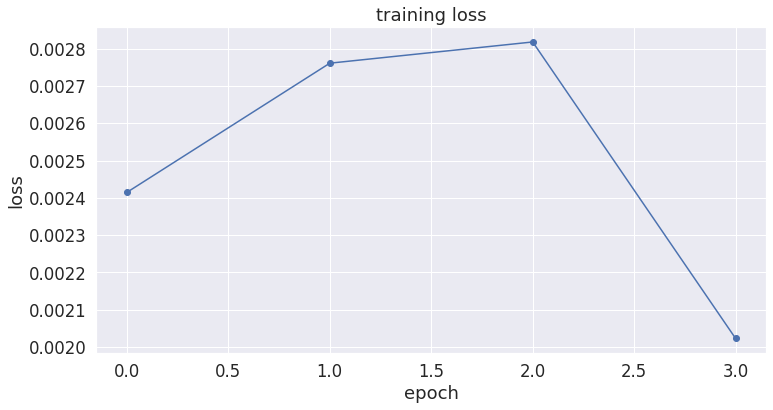

In [70]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

#label the plot

plt.title('training loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

# **data preparation the same as training for test**

In [79]:

test_input_ids = []




#for every sentence..
for sen in test_comments.comment:

  # report progress
  if ((len(input_ids) % 20000) == 0):
    print(' Read {:,} comments.'.format(len(input_ids)))

  encoded_sent = tokenizer.encode(
      sen,  #sentence to encode
      add_special_tokens = True, #[CLS] [SEP]
      #max_length = 512, 
      #return_tensors = 'pt
  )

  test_input_ids.append(encoded_sent)
  lengths.append(len(encoded_sent))


  print('{:>10,} test comments'.format(len(test_input_ids)))



#also retrieve the labels as a list

test_labels = test_comments.attack.to_numpy().astype(int)


print('{:>10,} positive.'.format(np.sum(test_labels)))
print('{:>10,} negative.'.format(len(test_labels) - np.sum(test_labels)))


#pad out input tokens with value 0 
test_input_ids = pad_sequences(test_input_ids, maxlen=max_len, dtype = 'long',
                          value = 0, truncating = 'post', padding = 'post' )
test_attention_masks = []

for seq in test_input_ids:

  test_att_mask = [float(test_token_id > 0) for test_token_id in seq]

  test_attention_masks.append(test_att_mask)


#convert to tensors
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)


#set batch
batch_size = 32


#create DataLoader

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size = batch_size )


Token indices sequence length is longer than the specified maximum sequence length for this model (1033 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (674 > 512). Running this sequence through the model will result in indexing errors


         1 test comments
         2 test comments
         3 test comments
         4 test comments
         5 test comments
         6 test comments
         7 test comments
         8 test comments
         9 test comments
        10 test comments
        11 test comments
        12 test comments
        13 test comments
        14 test comments
        15 test comments
        16 test comments
        17 test comments
        18 test comments
        19 test comments
        20 test comments
        21 test comments
        22 test comments
        23 test comments
        24 test comments
        25 test comments
        26 test comments
        27 test comments
        28 test comments
        29 test comments
        30 test comments
        31 test comments
        32 test comments
        33 test comments
        34 test comments
        35 test comments
        36 test comments
        37 test comments
        38 test comments
        39 test comments
        40 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (943 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (949 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

       137 test comments
       138 test comments
       139 test comments
       140 test comments
       141 test comments
       142 test comments
       143 test comments
       144 test comments
       145 test comments
       146 test comments
       147 test comments
       148 test comments
       149 test comments
       150 test comments
       151 test comments
       152 test comments
       153 test comments
       154 test comments
       155 test comments
       156 test comments
       157 test comments
       158 test comments
       159 test comments
       160 test comments
       161 test comments
       162 test comments
       163 test comments
       164 test comments
       165 test comments
       166 test comments
       167 test comments
       168 test comments
       169 test comments
       170 test comments
       171 test comments
       172 test comments
       173 test comments
       174 test comments
       175 test comments
       176 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1945 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1869 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for


       347 test comments
       348 test comments
       349 test comments
       350 test comments
       351 test comments
       352 test comments
       353 test comments
       354 test comments
       355 test comments
       356 test comments
       357 test comments
       358 test comments
       359 test comments
       360 test comments
       361 test comments
       362 test comments
       363 test comments
       364 test comments
       365 test comments
       366 test comments
       367 test comments
       368 test comments
       369 test comments
       370 test comments
       371 test comments
       372 test comments
       373 test comments
       374 test comments
       375 test comments
       376 test comments
       377 test comments
       378 test comments
       379 test comments
       380 test comments
       381 test comments
       382 test comments
       383 test comments
       384 test comments
       385 test comments
       386 test comments

Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1029 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


       439 test comments
       440 test comments
       441 test comments
       442 test comments
       443 test comments
       444 test comments
       445 test comments
       446 test comments
       447 test comments
       448 test comments
       449 test comments
       450 test comments
       451 test comments
       452 test comments
       453 test comments
       454 test comments
       455 test comments
       456 test comments
       457 test comments
       458 test comments
       459 test comments
       460 test comments
       461 test comments
       462 test comments
       463 test comments
       464 test comments
       465 test comments
       466 test comments
       467 test comments
       468 test comments
       469 test comments
       470 test comments
       471 test comments
       472 test comments
       473 test comments
       474 test comments
       475 test comments
       476 test comments
       477 test comments
       478 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (761 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (927 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

       588 test comments
       589 test comments
       590 test comments
       591 test comments
       592 test comments
       593 test comments
       594 test comments
       595 test comments
       596 test comments
       597 test comments
       598 test comments
       599 test comments
       600 test comments
       601 test comments
       602 test comments
       603 test comments
       604 test comments
       605 test comments
       606 test comments
       607 test comments
       608 test comments
       609 test comments
       610 test comments
       611 test comments
       612 test comments
       613 test comments
       614 test comments
       615 test comments
       616 test comments
       617 test comments
       618 test comments
       619 test comments
       620 test comments
       621 test comments
       622 test comments
       623 test comments
       624 test comments
       625 test comments
       626 test comments
       627 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1070 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (965 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (755 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (855 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1057 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

       761 test comments
       762 test comments
       763 test comments
       764 test comments
       765 test comments
       766 test comments
       767 test comments
       768 test comments
       769 test comments
       770 test comments
       771 test comments
       772 test comments
       773 test comments
       774 test comments
       775 test comments
       776 test comments
       777 test comments
       778 test comments
       779 test comments
       780 test comments
       781 test comments
       782 test comments
       783 test comments
       784 test comments
       785 test comments
       786 test comments
       787 test comments
       788 test comments
       789 test comments
       790 test comments
       791 test comments
       792 test comments
       793 test comments
       794 test comments
       795 test comments
       796 test comments
       797 test comments
       798 test comments
       799 test comments
       800 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1672 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (771 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4996 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (892 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

       850 test comments
       851 test comments
       852 test comments
       853 test comments
       854 test comments
       855 test comments
       856 test comments
       857 test comments
       858 test comments
       859 test comments
       860 test comments
       861 test comments
       862 test comments
       863 test comments
       864 test comments
       865 test comments
       866 test comments
       867 test comments
       868 test comments
       869 test comments
       870 test comments
       871 test comments
       872 test comments
       873 test comments
       874 test comments
       875 test comments
       876 test comments
       877 test comments
       878 test comments
       879 test comments
       880 test comments
       881 test comments
       882 test comments
       883 test comments
       884 test comments
       885 test comments
       886 test comments
       887 test comments
       888 test comments
       889 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (2089 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (799 > 512). Running this sequence through the model will result in indexing errors


       968 test comments
       969 test comments
       970 test comments
       971 test comments
       972 test comments
       973 test comments
       974 test comments
       975 test comments
       976 test comments
       977 test comments
       978 test comments
       979 test comments
       980 test comments
       981 test comments
       982 test comments
       983 test comments
       984 test comments
       985 test comments
       986 test comments
       987 test comments
       988 test comments
       989 test comments
       990 test comments
       991 test comments
       992 test comments
       993 test comments
       994 test comments
       995 test comments
       996 test comments
       997 test comments
       998 test comments
       999 test comments
     1,000 test comments
     1,001 test comments
     1,002 test comments
     1,003 test comments
     1,004 test comments
     1,005 test comments
     1,006 test comments
     1,007 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1060 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (823 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors


     1,146 test comments
     1,147 test comments
     1,148 test comments
     1,149 test comments
     1,150 test comments
     1,151 test comments
     1,152 test comments
     1,153 test comments
     1,154 test comments
     1,155 test comments
     1,156 test comments
     1,157 test comments
     1,158 test comments
     1,159 test comments
     1,160 test comments
     1,161 test comments
     1,162 test comments
     1,163 test comments
     1,164 test comments
     1,165 test comments
     1,166 test comments
     1,167 test comments
     1,168 test comments
     1,169 test comments
     1,170 test comments
     1,171 test comments
     1,172 test comments
     1,173 test comments
     1,174 test comments
     1,175 test comments
     1,176 test comments
     1,177 test comments
     1,178 test comments
     1,179 test comments
     1,180 test comments
     1,181 test comments
     1,182 test comments
     1,183 test comments
     1,184 test comments
     1,185 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1098 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1705 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2310 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors


     1,276 test comments
     1,277 test comments
     1,278 test comments
     1,279 test comments
     1,280 test comments
     1,281 test comments
     1,282 test comments
     1,283 test comments
     1,284 test comments
     1,285 test comments
     1,286 test comments
     1,287 test comments
     1,288 test comments
     1,289 test comments
     1,290 test comments
     1,291 test comments
     1,292 test comments
     1,293 test comments
     1,294 test comments
     1,295 test comments
     1,296 test comments
     1,297 test comments
     1,298 test comments
     1,299 test comments
     1,300 test comments
     1,301 test comments
     1,302 test comments
     1,303 test comments
     1,304 test comments
     1,305 test comments
     1,306 test comments
     1,307 test comments
     1,308 test comments
     1,309 test comments
     1,310 test comments
     1,311 test comments
     1,312 test comments
     1,313 test comments
     1,314 test comments
     1,315 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (835 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (975 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


     1,509 test comments
     1,510 test comments
     1,511 test comments
     1,512 test comments
     1,513 test comments
     1,514 test comments
     1,515 test comments
     1,516 test comments
     1,517 test comments
     1,518 test comments
     1,519 test comments
     1,520 test comments
     1,521 test comments
     1,522 test comments
     1,523 test comments
     1,524 test comments
     1,525 test comments
     1,526 test comments
     1,527 test comments
     1,528 test comments
     1,529 test comments
     1,530 test comments
     1,531 test comments
     1,532 test comments
     1,533 test comments
     1,534 test comments
     1,535 test comments
     1,536 test comments
     1,537 test comments
     1,538 test comments
     1,539 test comments
     1,540 test comments
     1,541 test comments
     1,542 test comments
     1,543 test comments
     1,544 test comments
     1,545 test comments
     1,546 test comments
     1,547 test comments
     1,548 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2045 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1614 > 512). Running this sequence through the model will result in indexing errors


     1,719 test comments
     1,720 test comments
     1,721 test comments
     1,722 test comments
     1,723 test comments
     1,724 test comments
     1,725 test comments
     1,726 test comments
     1,727 test comments
     1,728 test comments
     1,729 test comments
     1,730 test comments
     1,731 test comments
     1,732 test comments
     1,733 test comments
     1,734 test comments
     1,735 test comments
     1,736 test comments
     1,737 test comments
     1,738 test comments
     1,739 test comments
     1,740 test comments
     1,741 test comments
     1,742 test comments
     1,743 test comments
     1,744 test comments
     1,745 test comments
     1,746 test comments
     1,747 test comments
     1,748 test comments
     1,749 test comments
     1,750 test comments
     1,751 test comments
     1,752 test comments
     1,753 test comments
     1,754 test comments
     1,755 test comments
     1,756 test comments
     1,757 test comments
     1,758 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1939 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1144 > 512). Running this sequence through the model will result in indexing errors


     2,065 test comments
     2,066 test comments
     2,067 test comments
     2,068 test comments
     2,069 test comments
     2,070 test comments
     2,071 test comments
     2,072 test comments
     2,073 test comments
     2,074 test comments
     2,075 test comments
     2,076 test comments
     2,077 test comments
     2,078 test comments
     2,079 test comments
     2,080 test comments
     2,081 test comments
     2,082 test comments
     2,083 test comments
     2,084 test comments
     2,085 test comments
     2,086 test comments
     2,087 test comments
     2,088 test comments
     2,089 test comments
     2,090 test comments
     2,091 test comments
     2,092 test comments
     2,093 test comments
     2,094 test comments
     2,095 test comments
     2,096 test comments
     2,097 test comments
     2,098 test comments
     2,099 test comments
     2,100 test comments
     2,101 test comments
     2,102 test comments
     2,103 test comments
     2,104 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (745 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (767 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2982 > 512). Running this sequence through the model will result in indexing errors


     2,250 test comments
     2,251 test comments
     2,252 test comments
     2,253 test comments
     2,254 test comments
     2,255 test comments
     2,256 test comments
     2,257 test comments
     2,258 test comments
     2,259 test comments
     2,260 test comments
     2,261 test comments
     2,262 test comments
     2,263 test comments
     2,264 test comments
     2,265 test comments
     2,266 test comments
     2,267 test comments
     2,268 test comments
     2,269 test comments
     2,270 test comments
     2,271 test comments
     2,272 test comments
     2,273 test comments
     2,274 test comments
     2,275 test comments
     2,276 test comments
     2,277 test comments
     2,278 test comments
     2,279 test comments
     2,280 test comments
     2,281 test comments
     2,282 test comments
     2,283 test comments
     2,284 test comments
     2,285 test comments
     2,286 test comments
     2,287 test comments
     2,288 test comments
     2,289 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1094 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (699 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (740 > 512). Running this sequence through the model will result in indexing errors


     2,385 test comments
     2,386 test comments
     2,387 test comments
     2,388 test comments
     2,389 test comments
     2,390 test comments
     2,391 test comments
     2,392 test comments
     2,393 test comments
     2,394 test comments
     2,395 test comments
     2,396 test comments
     2,397 test comments
     2,398 test comments
     2,399 test comments
     2,400 test comments
     2,401 test comments
     2,402 test comments
     2,403 test comments
     2,404 test comments
     2,405 test comments
     2,406 test comments
     2,407 test comments
     2,408 test comments
     2,409 test comments
     2,410 test comments
     2,411 test comments
     2,412 test comments
     2,413 test comments
     2,414 test comments
     2,415 test comments
     2,416 test comments
     2,417 test comments
     2,418 test comments
     2,419 test comments
     2,420 test comments
     2,421 test comments
     2,422 test comments
     2,423 test comments
     2,424 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1083 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2068 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (784 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1365 > 512). Running this sequence through the model will result in indexing errors


     2,630 test comments
     2,631 test comments
     2,632 test comments
     2,633 test comments
     2,634 test comments
     2,635 test comments
     2,636 test comments
     2,637 test comments
     2,638 test comments
     2,639 test comments
     2,640 test comments
     2,641 test comments
     2,642 test comments
     2,643 test comments
     2,644 test comments
     2,645 test comments
     2,646 test comments
     2,647 test comments
     2,648 test comments
     2,649 test comments
     2,650 test comments
     2,651 test comments
     2,652 test comments
     2,653 test comments
     2,654 test comments
     2,655 test comments
     2,656 test comments
     2,657 test comments
     2,658 test comments
     2,659 test comments
     2,660 test comments
     2,661 test comments
     2,662 test comments
     2,663 test comments
     2,664 test comments
     2,665 test comments
     2,666 test comments
     2,667 test comments
     2,668 test comments
     2,669 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (979 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (619 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (853 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

     2,754 test comments
     2,755 test comments
     2,756 test comments
     2,757 test comments
     2,758 test comments
     2,759 test comments
     2,760 test comments
     2,761 test comments
     2,762 test comments
     2,763 test comments
     2,764 test comments
     2,765 test comments
     2,766 test comments
     2,767 test comments
     2,768 test comments
     2,769 test comments
     2,770 test comments
     2,771 test comments
     2,772 test comments
     2,773 test comments
     2,774 test comments
     2,775 test comments
     2,776 test comments
     2,777 test comments
     2,778 test comments
     2,779 test comments
     2,780 test comments
     2,781 test comments
     2,782 test comments
     2,783 test comments
     2,784 test comments
     2,785 test comments
     2,786 test comments
     2,787 test comments
     2,788 test comments
     2,789 test comments
     2,790 test comments
     2,791 test comments
     2,792 test comments
     2,793 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (747 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (710 > 512). Running this sequence through the model will result in indexing errors


     2,885 test comments
     2,886 test comments
     2,887 test comments
     2,888 test comments
     2,889 test comments
     2,890 test comments
     2,891 test comments
     2,892 test comments
     2,893 test comments
     2,894 test comments
     2,895 test comments
     2,896 test comments
     2,897 test comments
     2,898 test comments
     2,899 test comments
     2,900 test comments
     2,901 test comments
     2,902 test comments
     2,903 test comments
     2,904 test comments
     2,905 test comments
     2,906 test comments
     2,907 test comments
     2,908 test comments
     2,909 test comments
     2,910 test comments
     2,911 test comments
     2,912 test comments
     2,913 test comments
     2,914 test comments
     2,915 test comments
     2,916 test comments
     2,917 test comments
     2,918 test comments
     2,919 test comments
     2,920 test comments
     2,921 test comments
     2,922 test comments
     2,923 test comments
     2,924 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (814 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3336 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1016 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

     3,053 test comments
     3,054 test comments
     3,055 test comments
     3,056 test comments
     3,057 test comments
     3,058 test comments
     3,059 test comments
     3,060 test comments
     3,061 test comments
     3,062 test comments
     3,063 test comments
     3,064 test comments
     3,065 test comments
     3,066 test comments
     3,067 test comments
     3,068 test comments
     3,069 test comments
     3,070 test comments
     3,071 test comments
     3,072 test comments
     3,073 test comments
     3,074 test comments
     3,075 test comments
     3,076 test comments
     3,077 test comments
     3,078 test comments
     3,079 test comments
     3,080 test comments
     3,081 test comments
     3,082 test comments
     3,083 test comments
     3,084 test comments
     3,085 test comments
     3,086 test comments
     3,087 test comments
     3,088 test comments
     3,089 test comments
     3,090 test comments
     3,091 test comments
     3,092 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5799 > 512). Running this sequence through the model will result in indexing errors


     3,207 test comments
     3,208 test comments
     3,209 test comments
     3,210 test comments
     3,211 test comments
     3,212 test comments
     3,213 test comments
     3,214 test comments
     3,215 test comments
     3,216 test comments
     3,217 test comments
     3,218 test comments
     3,219 test comments
     3,220 test comments
     3,221 test comments
     3,222 test comments
     3,223 test comments
     3,224 test comments
     3,225 test comments
     3,226 test comments
     3,227 test comments
     3,228 test comments
     3,229 test comments
     3,230 test comments
     3,231 test comments
     3,232 test comments
     3,233 test comments
     3,234 test comments
     3,235 test comments
     3,236 test comments
     3,237 test comments
     3,238 test comments
     3,239 test comments
     3,240 test comments
     3,241 test comments
     3,242 test comments
     3,243 test comments
     3,244 test comments
     3,245 test comments
     3,246 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1074 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (736 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (882 > 512). Running this sequence through the model will result in indexing errors


     3,361 test comments
     3,362 test comments
     3,363 test comments
     3,364 test comments
     3,365 test comments
     3,366 test comments
     3,367 test comments
     3,368 test comments
     3,369 test comments
     3,370 test comments
     3,371 test comments
     3,372 test comments
     3,373 test comments
     3,374 test comments
     3,375 test comments
     3,376 test comments
     3,377 test comments
     3,378 test comments
     3,379 test comments
     3,380 test comments
     3,381 test comments
     3,382 test comments
     3,383 test comments
     3,384 test comments
     3,385 test comments
     3,386 test comments
     3,387 test comments
     3,388 test comments
     3,389 test comments
     3,390 test comments
     3,391 test comments
     3,392 test comments
     3,393 test comments
     3,394 test comments
     3,395 test comments
     3,396 test comments
     3,397 test comments
     3,398 test comments
     3,399 test comments
     3,400 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (2032 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1054 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2062 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1094 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

     3,504 test comments
     3,505 test comments
     3,506 test comments
     3,507 test comments
     3,508 test comments
     3,509 test comments
     3,510 test comments
     3,511 test comments
     3,512 test comments
     3,513 test comments
     3,514 test comments
     3,515 test comments
     3,516 test comments
     3,517 test comments
     3,518 test comments
     3,519 test comments
     3,520 test comments
     3,521 test comments
     3,522 test comments
     3,523 test comments
     3,524 test comments
     3,525 test comments
     3,526 test comments
     3,527 test comments
     3,528 test comments
     3,529 test comments
     3,530 test comments
     3,531 test comments
     3,532 test comments
     3,533 test comments
     3,534 test comments
     3,535 test comments
     3,536 test comments
     3,537 test comments
     3,538 test comments
     3,539 test comments
     3,540 test comments
     3,541 test comments
     3,542 test comments
     3,543 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1569 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (959 > 512). Running this sequence through the model will result in indexing errors


     3,651 test comments
     3,652 test comments
     3,653 test comments
     3,654 test comments
     3,655 test comments
     3,656 test comments
     3,657 test comments
     3,658 test comments
     3,659 test comments
     3,660 test comments
     3,661 test comments
     3,662 test comments
     3,663 test comments
     3,664 test comments
     3,665 test comments
     3,666 test comments
     3,667 test comments
     3,668 test comments
     3,669 test comments
     3,670 test comments
     3,671 test comments
     3,672 test comments
     3,673 test comments
     3,674 test comments
     3,675 test comments
     3,676 test comments
     3,677 test comments
     3,678 test comments
     3,679 test comments
     3,680 test comments
     3,681 test comments
     3,682 test comments
     3,683 test comments
     3,684 test comments
     3,685 test comments
     3,686 test comments
     3,687 test comments
     3,688 test comments
     3,689 test comments
     3,690 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (721 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (804 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors


     3,818 test comments
     3,819 test comments
     3,820 test comments
     3,821 test comments
     3,822 test comments
     3,823 test comments
     3,824 test comments
     3,825 test comments
     3,826 test comments
     3,827 test comments
     3,828 test comments
     3,829 test comments
     3,830 test comments
     3,831 test comments
     3,832 test comments
     3,833 test comments
     3,834 test comments
     3,835 test comments
     3,836 test comments
     3,837 test comments
     3,838 test comments
     3,839 test comments
     3,840 test comments
     3,841 test comments
     3,842 test comments
     3,843 test comments
     3,844 test comments
     3,845 test comments
     3,846 test comments
     3,847 test comments
     3,848 test comments
     3,849 test comments
     3,850 test comments
     3,851 test comments
     3,852 test comments
     3,853 test comments
     3,854 test comments
     3,855 test comments
     3,856 test comments
     3,857 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (964 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (696 > 512). Running this sequence through the model will result in indexing errors


     4,040 test comments
     4,041 test comments
     4,042 test comments
     4,043 test comments
     4,044 test comments
     4,045 test comments
     4,046 test comments
     4,047 test comments
     4,048 test comments
     4,049 test comments
     4,050 test comments
     4,051 test comments
     4,052 test comments
     4,053 test comments
     4,054 test comments
     4,055 test comments
     4,056 test comments
     4,057 test comments
     4,058 test comments
     4,059 test comments
     4,060 test comments
     4,061 test comments
     4,062 test comments
     4,063 test comments
     4,064 test comments
     4,065 test comments
     4,066 test comments
     4,067 test comments
     4,068 test comments
     4,069 test comments
     4,070 test comments
     4,071 test comments
     4,072 test comments
     4,073 test comments
     4,074 test comments
     4,075 test comments
     4,076 test comments
     4,077 test comments
     4,078 test comments
     4,079 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (859 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (682 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1805 > 512). Running this sequence through the model will result in indexing errors


     4,161 test comments
     4,162 test comments
     4,163 test comments
     4,164 test comments
     4,165 test comments
     4,166 test comments
     4,167 test comments
     4,168 test comments
     4,169 test comments
     4,170 test comments
     4,171 test comments
     4,172 test comments
     4,173 test comments
     4,174 test comments
     4,175 test comments
     4,176 test comments
     4,177 test comments
     4,178 test comments
     4,179 test comments
     4,180 test comments
     4,181 test comments
     4,182 test comments
     4,183 test comments
     4,184 test comments
     4,185 test comments
     4,186 test comments
     4,187 test comments
     4,188 test comments
     4,189 test comments
     4,190 test comments
     4,191 test comments
     4,192 test comments
     4,193 test comments
     4,194 test comments
     4,195 test comments
     4,196 test comments
     4,197 test comments
     4,198 test comments
     4,199 test comments
     4,200 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (2185 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors


     4,306 test comments
     4,307 test comments
     4,308 test comments
     4,309 test comments
     4,310 test comments
     4,311 test comments
     4,312 test comments
     4,313 test comments
     4,314 test comments
     4,315 test comments
     4,316 test comments
     4,317 test comments
     4,318 test comments
     4,319 test comments
     4,320 test comments
     4,321 test comments
     4,322 test comments
     4,323 test comments
     4,324 test comments
     4,325 test comments
     4,326 test comments
     4,327 test comments
     4,328 test comments
     4,329 test comments
     4,330 test comments
     4,331 test comments
     4,332 test comments
     4,333 test comments
     4,334 test comments
     4,335 test comments
     4,336 test comments
     4,337 test comments
     4,338 test comments
     4,339 test comments
     4,340 test comments
     4,341 test comments
     4,342 test comments
     4,343 test comments
     4,344 test comments
     4,345 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (906 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1768 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

     4,478 test comments
     4,479 test comments
     4,480 test comments
     4,481 test comments
     4,482 test comments
     4,483 test comments
     4,484 test comments
     4,485 test comments
     4,486 test comments
     4,487 test comments
     4,488 test comments
     4,489 test comments
     4,490 test comments
     4,491 test comments
     4,492 test comments
     4,493 test comments
     4,494 test comments
     4,495 test comments
     4,496 test comments
     4,497 test comments
     4,498 test comments
     4,499 test comments
     4,500 test comments
     4,501 test comments
     4,502 test comments
     4,503 test comments
     4,504 test comments
     4,505 test comments
     4,506 test comments
     4,507 test comments
     4,508 test comments
     4,509 test comments
     4,510 test comments
     4,511 test comments
     4,512 test comments
     4,513 test comments
     4,514 test comments
     4,515 test comments
     4,516 test comments
     4,517 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (911 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (833 > 512). Running this sequence through the model will result in indexing errors


     4,619 test comments
     4,620 test comments
     4,621 test comments
     4,622 test comments
     4,623 test comments
     4,624 test comments
     4,625 test comments
     4,626 test comments
     4,627 test comments
     4,628 test comments
     4,629 test comments
     4,630 test comments
     4,631 test comments
     4,632 test comments
     4,633 test comments
     4,634 test comments
     4,635 test comments
     4,636 test comments
     4,637 test comments
     4,638 test comments
     4,639 test comments
     4,640 test comments
     4,641 test comments
     4,642 test comments
     4,643 test comments
     4,644 test comments
     4,645 test comments
     4,646 test comments
     4,647 test comments
     4,648 test comments
     4,649 test comments
     4,650 test comments
     4,651 test comments
     4,652 test comments
     4,653 test comments
     4,654 test comments
     4,655 test comments
     4,656 test comments
     4,657 test comments
     4,658 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (595 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1317 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3989 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors


     4,804 test comments
     4,805 test comments
     4,806 test comments
     4,807 test comments
     4,808 test comments
     4,809 test comments
     4,810 test comments
     4,811 test comments
     4,812 test comments
     4,813 test comments
     4,814 test comments
     4,815 test comments
     4,816 test comments
     4,817 test comments
     4,818 test comments
     4,819 test comments
     4,820 test comments
     4,821 test comments
     4,822 test comments
     4,823 test comments
     4,824 test comments
     4,825 test comments
     4,826 test comments
     4,827 test comments
     4,828 test comments
     4,829 test comments
     4,830 test comments
     4,831 test comments
     4,832 test comments
     4,833 test comments
     4,834 test comments
     4,835 test comments
     4,836 test comments
     4,837 test comments
     4,838 test comments
     4,839 test comments
     4,840 test comments
     4,841 test comments
     4,842 test comments
     4,843 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (896 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2275 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (840 > 512). Running this sequence through the model will result in indexing errors


     4,946 test comments
     4,947 test comments
     4,948 test comments
     4,949 test comments
     4,950 test comments
     4,951 test comments
     4,952 test comments
     4,953 test comments
     4,954 test comments
     4,955 test comments
     4,956 test comments
     4,957 test comments
     4,958 test comments
     4,959 test comments
     4,960 test comments
     4,961 test comments
     4,962 test comments
     4,963 test comments
     4,964 test comments
     4,965 test comments
     4,966 test comments
     4,967 test comments
     4,968 test comments
     4,969 test comments
     4,970 test comments
     4,971 test comments
     4,972 test comments
     4,973 test comments
     4,974 test comments
     4,975 test comments
     4,976 test comments
     4,977 test comments
     4,978 test comments
     4,979 test comments
     4,980 test comments
     4,981 test comments
     4,982 test comments
     4,983 test comments
     4,984 test comments
     4,985 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (982 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (758 > 512). Running this sequence through the model will result in indexing errors


     5,088 test comments
     5,089 test comments
     5,090 test comments
     5,091 test comments
     5,092 test comments
     5,093 test comments
     5,094 test comments
     5,095 test comments
     5,096 test comments
     5,097 test comments
     5,098 test comments
     5,099 test comments
     5,100 test comments
     5,101 test comments
     5,102 test comments
     5,103 test comments
     5,104 test comments
     5,105 test comments
     5,106 test comments
     5,107 test comments
     5,108 test comments
     5,109 test comments
     5,110 test comments
     5,111 test comments
     5,112 test comments
     5,113 test comments
     5,114 test comments
     5,115 test comments
     5,116 test comments
     5,117 test comments
     5,118 test comments
     5,119 test comments
     5,120 test comments
     5,121 test comments
     5,122 test comments
     5,123 test comments
     5,124 test comments
     5,125 test comments
     5,126 test comments
     5,127 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors



     5,226 test comments
     5,227 test comments
     5,228 test comments
     5,229 test comments
     5,230 test comments
     5,231 test comments
     5,232 test comments
     5,233 test comments
     5,234 test comments
     5,235 test comments
     5,236 test comments
     5,237 test comments
     5,238 test comments
     5,239 test comments
     5,240 test comments
     5,241 test comments
     5,242 test comments
     5,243 test comments
     5,244 test comments
     5,245 test comments
     5,246 test comments
     5,247 test comments
     5,248 test comments
     5,249 test comments
     5,250 test comments
     5,251 test comments
     5,252 test comments
     5,253 test comments
     5,254 test comments
     5,255 test comments
     5,256 test comments
     5,257 test comments
     5,258 test comments
     5,259 test comments
     5,260 test comments
     5,261 test comments
     5,262 test comments
     5,263 test comments
     5,264 test comments
     5,265 test comments

Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1745 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (832 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (927 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

     5,575 test comments
     5,576 test comments
     5,577 test comments
     5,578 test comments
     5,579 test comments
     5,580 test comments
     5,581 test comments
     5,582 test comments
     5,583 test comments
     5,584 test comments
     5,585 test comments
     5,586 test comments
     5,587 test comments
     5,588 test comments
     5,589 test comments
     5,590 test comments
     5,591 test comments
     5,592 test comments
     5,593 test comments
     5,594 test comments
     5,595 test comments
     5,596 test comments
     5,597 test comments
     5,598 test comments
     5,599 test comments
     5,600 test comments
     5,601 test comments
     5,602 test comments
     5,603 test comments
     5,604 test comments
     5,605 test comments
     5,606 test comments
     5,607 test comments
     5,608 test comments
     5,609 test comments
     5,610 test comments
     5,611 test comments
     5,612 test comments
     5,613 test comments
     5,614 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (909 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (879 > 512). Running this sequence through the model will result in indexing errors


     5,766 test comments
     5,767 test comments
     5,768 test comments
     5,769 test comments
     5,770 test comments
     5,771 test comments
     5,772 test comments
     5,773 test comments
     5,774 test comments
     5,775 test comments
     5,776 test comments
     5,777 test comments
     5,778 test comments
     5,779 test comments
     5,780 test comments
     5,781 test comments
     5,782 test comments
     5,783 test comments
     5,784 test comments
     5,785 test comments
     5,786 test comments
     5,787 test comments
     5,788 test comments
     5,789 test comments
     5,790 test comments
     5,791 test comments
     5,792 test comments
     5,793 test comments
     5,794 test comments
     5,795 test comments
     5,796 test comments
     5,797 test comments
     5,798 test comments
     5,799 test comments
     5,800 test comments
     5,801 test comments
     5,802 test comments
     5,803 test comments
     5,804 test comments
     5,805 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (633 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (946 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1960 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (795 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

     5,973 test comments
     5,974 test comments
     5,975 test comments
     5,976 test comments
     5,977 test comments
     5,978 test comments
     5,979 test comments
     5,980 test comments
     5,981 test comments
     5,982 test comments
     5,983 test comments
     5,984 test comments
     5,985 test comments
     5,986 test comments
     5,987 test comments
     5,988 test comments
     5,989 test comments
     5,990 test comments
     5,991 test comments
     5,992 test comments
     5,993 test comments
     5,994 test comments
     5,995 test comments
     5,996 test comments
     5,997 test comments
     5,998 test comments
     5,999 test comments
     6,000 test comments
     6,001 test comments
     6,002 test comments
     6,003 test comments
     6,004 test comments
     6,005 test comments
     6,006 test comments
     6,007 test comments
     6,008 test comments
     6,009 test comments
     6,010 test comments
     6,011 test comments
     6,012 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1273 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (784 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (978 > 512). Running this sequence through the model will result in indexing errors


     6,136 test comments
     6,137 test comments
     6,138 test comments
     6,139 test comments
     6,140 test comments
     6,141 test comments
     6,142 test comments
     6,143 test comments
     6,144 test comments
     6,145 test comments
     6,146 test comments
     6,147 test comments
     6,148 test comments
     6,149 test comments
     6,150 test comments
     6,151 test comments
     6,152 test comments
     6,153 test comments
     6,154 test comments
     6,155 test comments
     6,156 test comments
     6,157 test comments
     6,158 test comments
     6,159 test comments
     6,160 test comments
     6,161 test comments
     6,162 test comments
     6,163 test comments
     6,164 test comments
     6,165 test comments
     6,166 test comments
     6,167 test comments
     6,168 test comments
     6,169 test comments
     6,170 test comments
     6,171 test comments
     6,172 test comments
     6,173 test comments
     6,174 test comments
     6,175 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1011 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1870 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (813 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (780 > 512). Running this sequence through the model will result in indexing errors


     6,289 test comments
     6,290 test comments
     6,291 test comments
     6,292 test comments
     6,293 test comments
     6,294 test comments
     6,295 test comments
     6,296 test comments
     6,297 test comments
     6,298 test comments
     6,299 test comments
     6,300 test comments
     6,301 test comments
     6,302 test comments
     6,303 test comments
     6,304 test comments
     6,305 test comments
     6,306 test comments
     6,307 test comments
     6,308 test comments
     6,309 test comments
     6,310 test comments
     6,311 test comments
     6,312 test comments
     6,313 test comments
     6,314 test comments
     6,315 test comments
     6,316 test comments
     6,317 test comments
     6,318 test comments
     6,319 test comments
     6,320 test comments
     6,321 test comments
     6,322 test comments
     6,323 test comments
     6,324 test comments
     6,325 test comments
     6,326 test comments
     6,327 test comments
     6,328 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (2821 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (666 > 512). Running this sequence through the model will result in indexing errors


     6,415 test comments
     6,416 test comments
     6,417 test comments
     6,418 test comments
     6,419 test comments
     6,420 test comments
     6,421 test comments
     6,422 test comments
     6,423 test comments
     6,424 test comments
     6,425 test comments
     6,426 test comments
     6,427 test comments
     6,428 test comments
     6,429 test comments
     6,430 test comments
     6,431 test comments
     6,432 test comments
     6,433 test comments
     6,434 test comments
     6,435 test comments
     6,436 test comments
     6,437 test comments
     6,438 test comments
     6,439 test comments
     6,440 test comments
     6,441 test comments
     6,442 test comments
     6,443 test comments
     6,444 test comments
     6,445 test comments
     6,446 test comments
     6,447 test comments
     6,448 test comments
     6,449 test comments
     6,450 test comments
     6,451 test comments
     6,452 test comments
     6,453 test comments
     6,454 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1050 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2405 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1237 > 512). Running this sequence through the model will result in indexing errors


     6,558 test comments
     6,559 test comments
     6,560 test comments
     6,561 test comments
     6,562 test comments
     6,563 test comments
     6,564 test comments
     6,565 test comments
     6,566 test comments
     6,567 test comments
     6,568 test comments
     6,569 test comments
     6,570 test comments
     6,571 test comments
     6,572 test comments
     6,573 test comments
     6,574 test comments
     6,575 test comments
     6,576 test comments
     6,577 test comments
     6,578 test comments
     6,579 test comments
     6,580 test comments
     6,581 test comments
     6,582 test comments
     6,583 test comments
     6,584 test comments
     6,585 test comments
     6,586 test comments
     6,587 test comments
     6,588 test comments
     6,589 test comments
     6,590 test comments
     6,591 test comments
     6,592 test comments
     6,593 test comments
     6,594 test comments
     6,595 test comments
     6,596 test comments
     6,597 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1920 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


     6,675 test comments
     6,676 test comments
     6,677 test comments
     6,678 test comments
     6,679 test comments
     6,680 test comments
     6,681 test comments
     6,682 test comments
     6,683 test comments
     6,684 test comments
     6,685 test comments
     6,686 test comments
     6,687 test comments
     6,688 test comments
     6,689 test comments
     6,690 test comments
     6,691 test comments
     6,692 test comments
     6,693 test comments
     6,694 test comments
     6,695 test comments
     6,696 test comments
     6,697 test comments
     6,698 test comments
     6,699 test comments
     6,700 test comments
     6,701 test comments
     6,702 test comments
     6,703 test comments
     6,704 test comments
     6,705 test comments
     6,706 test comments
     6,707 test comments
     6,708 test comments
     6,709 test comments
     6,710 test comments
     6,711 test comments
     6,712 test comments
     6,713 test comments
     6,714 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1489 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


     6,849 test comments
     6,850 test comments
     6,851 test comments
     6,852 test comments
     6,853 test comments
     6,854 test comments
     6,855 test comments
     6,856 test comments
     6,857 test comments
     6,858 test comments
     6,859 test comments
     6,860 test comments
     6,861 test comments
     6,862 test comments
     6,863 test comments
     6,864 test comments
     6,865 test comments
     6,866 test comments
     6,867 test comments
     6,868 test comments
     6,869 test comments
     6,870 test comments
     6,871 test comments
     6,872 test comments
     6,873 test comments
     6,874 test comments
     6,875 test comments
     6,876 test comments
     6,877 test comments
     6,878 test comments
     6,879 test comments
     6,880 test comments
     6,881 test comments
     6,882 test comments
     6,883 test comments
     6,884 test comments
     6,885 test comments
     6,886 test comments
     6,887 test comments
     6,888 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2104 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1537 > 512). Running this sequence through the model will result in indexing errors


     7,035 test comments
     7,036 test comments
     7,037 test comments
     7,038 test comments
     7,039 test comments
     7,040 test comments
     7,041 test comments
     7,042 test comments
     7,043 test comments
     7,044 test comments
     7,045 test comments
     7,046 test comments
     7,047 test comments
     7,048 test comments
     7,049 test comments
     7,050 test comments
     7,051 test comments
     7,052 test comments
     7,053 test comments
     7,054 test comments
     7,055 test comments
     7,056 test comments
     7,057 test comments
     7,058 test comments
     7,059 test comments
     7,060 test comments
     7,061 test comments
     7,062 test comments
     7,063 test comments
     7,064 test comments
     7,065 test comments
     7,066 test comments
     7,067 test comments
     7,068 test comments
     7,069 test comments
     7,070 test comments
     7,071 test comments
     7,072 test comments
     7,073 test comments
     7,074 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (961 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1199 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1049 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1084 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


     7,167 test comments
     7,168 test comments
     7,169 test comments
     7,170 test comments
     7,171 test comments
     7,172 test comments
     7,173 test comments
     7,174 test comments
     7,175 test comments
     7,176 test comments
     7,177 test comments
     7,178 test comments
     7,179 test comments
     7,180 test comments
     7,181 test comments
     7,182 test comments
     7,183 test comments
     7,184 test comments
     7,185 test comments
     7,186 test comments
     7,187 test comments
     7,188 test comments
     7,189 test comments
     7,190 test comments
     7,191 test comments
     7,192 test comments
     7,193 test comments
     7,194 test comments
     7,195 test comments
     7,196 test comments
     7,197 test comments
     7,198 test comments
     7,199 test comments
     7,200 test comments
     7,201 test comments
     7,202 test comments
     7,203 test comments
     7,204 test comments
     7,205 test comments
     7,206 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1885 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors


     7,321 test comments
     7,322 test comments
     7,323 test comments
     7,324 test comments
     7,325 test comments
     7,326 test comments
     7,327 test comments
     7,328 test comments
     7,329 test comments
     7,330 test comments
     7,331 test comments
     7,332 test comments
     7,333 test comments
     7,334 test comments
     7,335 test comments
     7,336 test comments
     7,337 test comments
     7,338 test comments
     7,339 test comments
     7,340 test comments
     7,341 test comments
     7,342 test comments
     7,343 test comments
     7,344 test comments
     7,345 test comments
     7,346 test comments
     7,347 test comments
     7,348 test comments
     7,349 test comments
     7,350 test comments
     7,351 test comments
     7,352 test comments
     7,353 test comments
     7,354 test comments
     7,355 test comments
     7,356 test comments
     7,357 test comments
     7,358 test comments
     7,359 test comments
     7,360 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (769 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2860 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2458 > 512). Running this sequence through the model will result in indexing errors


     7,455 test comments
     7,456 test comments
     7,457 test comments
     7,458 test comments
     7,459 test comments
     7,460 test comments
     7,461 test comments
     7,462 test comments
     7,463 test comments
     7,464 test comments
     7,465 test comments
     7,466 test comments
     7,467 test comments
     7,468 test comments
     7,469 test comments
     7,470 test comments
     7,471 test comments
     7,472 test comments
     7,473 test comments
     7,474 test comments
     7,475 test comments
     7,476 test comments
     7,477 test comments
     7,478 test comments
     7,479 test comments
     7,480 test comments
     7,481 test comments
     7,482 test comments
     7,483 test comments
     7,484 test comments
     7,485 test comments
     7,486 test comments
     7,487 test comments
     7,488 test comments
     7,489 test comments
     7,490 test comments
     7,491 test comments
     7,492 test comments
     7,493 test comments
     7,494 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (864 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


     7,619 test comments
     7,620 test comments
     7,621 test comments
     7,622 test comments
     7,623 test comments
     7,624 test comments
     7,625 test comments
     7,626 test comments
     7,627 test comments
     7,628 test comments
     7,629 test comments
     7,630 test comments
     7,631 test comments
     7,632 test comments
     7,633 test comments
     7,634 test comments
     7,635 test comments
     7,636 test comments
     7,637 test comments
     7,638 test comments
     7,639 test comments
     7,640 test comments
     7,641 test comments
     7,642 test comments
     7,643 test comments
     7,644 test comments
     7,645 test comments
     7,646 test comments
     7,647 test comments
     7,648 test comments
     7,649 test comments
     7,650 test comments
     7,651 test comments
     7,652 test comments
     7,653 test comments
     7,654 test comments
     7,655 test comments
     7,656 test comments
     7,657 test comments
     7,658 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (4961 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1726 > 512). Running this sequence through the model will result in indexing errors


     7,782 test comments
     7,783 test comments
     7,784 test comments
     7,785 test comments
     7,786 test comments
     7,787 test comments
     7,788 test comments
     7,789 test comments
     7,790 test comments
     7,791 test comments
     7,792 test comments
     7,793 test comments
     7,794 test comments
     7,795 test comments
     7,796 test comments
     7,797 test comments
     7,798 test comments
     7,799 test comments
     7,800 test comments
     7,801 test comments
     7,802 test comments
     7,803 test comments
     7,804 test comments
     7,805 test comments
     7,806 test comments
     7,807 test comments
     7,808 test comments
     7,809 test comments
     7,810 test comments
     7,811 test comments
     7,812 test comments
     7,813 test comments
     7,814 test comments
     7,815 test comments
     7,816 test comments
     7,817 test comments
     7,818 test comments
     7,819 test comments
     7,820 test comments
     7,821 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (887 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


     7,985 test comments
     7,986 test comments
     7,987 test comments
     7,988 test comments
     7,989 test comments
     7,990 test comments
     7,991 test comments
     7,992 test comments
     7,993 test comments
     7,994 test comments
     7,995 test comments
     7,996 test comments
     7,997 test comments
     7,998 test comments
     7,999 test comments
     8,000 test comments
     8,001 test comments
     8,002 test comments
     8,003 test comments
     8,004 test comments
     8,005 test comments
     8,006 test comments
     8,007 test comments
     8,008 test comments
     8,009 test comments
     8,010 test comments
     8,011 test comments
     8,012 test comments
     8,013 test comments
     8,014 test comments
     8,015 test comments
     8,016 test comments
     8,017 test comments
     8,018 test comments
     8,019 test comments
     8,020 test comments
     8,021 test comments
     8,022 test comments
     8,023 test comments
     8,024 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1494 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1121 > 512). Running this sequence through the model will result in indexing errors


     8,158 test comments
     8,159 test comments
     8,160 test comments
     8,161 test comments
     8,162 test comments
     8,163 test comments
     8,164 test comments
     8,165 test comments
     8,166 test comments
     8,167 test comments
     8,168 test comments
     8,169 test comments
     8,170 test comments
     8,171 test comments
     8,172 test comments
     8,173 test comments
     8,174 test comments
     8,175 test comments
     8,176 test comments
     8,177 test comments
     8,178 test comments
     8,179 test comments
     8,180 test comments
     8,181 test comments
     8,182 test comments
     8,183 test comments
     8,184 test comments
     8,185 test comments
     8,186 test comments
     8,187 test comments
     8,188 test comments
     8,189 test comments
     8,190 test comments
     8,191 test comments
     8,192 test comments
     8,193 test comments
     8,194 test comments
     8,195 test comments
     8,196 test comments
     8,197 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (974 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1326 > 512). Running this sequence through the model will result in indexing errors


     8,344 test comments
     8,345 test comments
     8,346 test comments
     8,347 test comments
     8,348 test comments
     8,349 test comments
     8,350 test comments
     8,351 test comments
     8,352 test comments
     8,353 test comments
     8,354 test comments
     8,355 test comments
     8,356 test comments
     8,357 test comments
     8,358 test comments
     8,359 test comments
     8,360 test comments
     8,361 test comments
     8,362 test comments
     8,363 test comments
     8,364 test comments
     8,365 test comments
     8,366 test comments
     8,367 test comments
     8,368 test comments
     8,369 test comments
     8,370 test comments
     8,371 test comments
     8,372 test comments
     8,373 test comments
     8,374 test comments
     8,375 test comments
     8,376 test comments
     8,377 test comments
     8,378 test comments
     8,379 test comments
     8,380 test comments
     8,381 test comments
     8,382 test comments
     8,383 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (901 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (950 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2692 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors


     8,546 test comments
     8,547 test comments
     8,548 test comments
     8,549 test comments
     8,550 test comments
     8,551 test comments
     8,552 test comments
     8,553 test comments
     8,554 test comments
     8,555 test comments
     8,556 test comments
     8,557 test comments
     8,558 test comments
     8,559 test comments
     8,560 test comments
     8,561 test comments
     8,562 test comments
     8,563 test comments
     8,564 test comments
     8,565 test comments
     8,566 test comments
     8,567 test comments
     8,568 test comments
     8,569 test comments
     8,570 test comments
     8,571 test comments
     8,572 test comments
     8,573 test comments
     8,574 test comments
     8,575 test comments
     8,576 test comments
     8,577 test comments
     8,578 test comments
     8,579 test comments
     8,580 test comments
     8,581 test comments
     8,582 test comments
     8,583 test comments
     8,584 test comments
     8,585 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (700 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2089 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


     8,708 test comments
     8,709 test comments
     8,710 test comments
     8,711 test comments
     8,712 test comments
     8,713 test comments
     8,714 test comments
     8,715 test comments
     8,716 test comments
     8,717 test comments
     8,718 test comments
     8,719 test comments
     8,720 test comments
     8,721 test comments
     8,722 test comments
     8,723 test comments
     8,724 test comments
     8,725 test comments
     8,726 test comments
     8,727 test comments
     8,728 test comments
     8,729 test comments
     8,730 test comments
     8,731 test comments
     8,732 test comments
     8,733 test comments
     8,734 test comments
     8,735 test comments
     8,736 test comments
     8,737 test comments
     8,738 test comments
     8,739 test comments
     8,740 test comments
     8,741 test comments
     8,742 test comments
     8,743 test comments
     8,744 test comments
     8,745 test comments
     8,746 test comments
     8,747 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1165 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (890 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (894 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

     8,931 test comments
     8,932 test comments
     8,933 test comments
     8,934 test comments
     8,935 test comments
     8,936 test comments
     8,937 test comments
     8,938 test comments
     8,939 test comments
     8,940 test comments
     8,941 test comments
     8,942 test comments
     8,943 test comments
     8,944 test comments
     8,945 test comments
     8,946 test comments
     8,947 test comments
     8,948 test comments
     8,949 test comments
     8,950 test comments
     8,951 test comments
     8,952 test comments
     8,953 test comments
     8,954 test comments
     8,955 test comments
     8,956 test comments
     8,957 test comments
     8,958 test comments
     8,959 test comments
     8,960 test comments
     8,961 test comments
     8,962 test comments
     8,963 test comments
     8,964 test comments
     8,965 test comments
     8,966 test comments
     8,967 test comments
     8,968 test comments
     8,969 test comments
     8,970 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (862 > 512). Running this sequence through the model will result in indexing errors


     9,042 test comments
     9,043 test comments
     9,044 test comments
     9,045 test comments
     9,046 test comments
     9,047 test comments
     9,048 test comments
     9,049 test comments
     9,050 test comments
     9,051 test comments
     9,052 test comments
     9,053 test comments
     9,054 test comments
     9,055 test comments
     9,056 test comments
     9,057 test comments
     9,058 test comments
     9,059 test comments
     9,060 test comments
     9,061 test comments
     9,062 test comments
     9,063 test comments
     9,064 test comments
     9,065 test comments
     9,066 test comments
     9,067 test comments
     9,068 test comments
     9,069 test comments
     9,070 test comments
     9,071 test comments
     9,072 test comments
     9,073 test comments
     9,074 test comments
     9,075 test comments
     9,076 test comments
     9,077 test comments
     9,078 test comments
     9,079 test comments
     9,080 test comments
     9,081 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1064 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1080 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (823 > 512). Running this sequence through the model will result in indexing errors


     9,248 test comments
     9,249 test comments
     9,250 test comments
     9,251 test comments
     9,252 test comments
     9,253 test comments
     9,254 test comments
     9,255 test comments
     9,256 test comments
     9,257 test comments
     9,258 test comments
     9,259 test comments
     9,260 test comments
     9,261 test comments
     9,262 test comments
     9,263 test comments
     9,264 test comments
     9,265 test comments
     9,266 test comments
     9,267 test comments
     9,268 test comments
     9,269 test comments
     9,270 test comments
     9,271 test comments
     9,272 test comments
     9,273 test comments
     9,274 test comments
     9,275 test comments
     9,276 test comments
     9,277 test comments
     9,278 test comments
     9,279 test comments
     9,280 test comments
     9,281 test comments
     9,282 test comments
     9,283 test comments
     9,284 test comments
     9,285 test comments
     9,286 test comments
     9,287 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1102 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

     9,370 test comments
     9,371 test comments
     9,372 test comments
     9,373 test comments
     9,374 test comments
     9,375 test comments
     9,376 test comments
     9,377 test comments
     9,378 test comments
     9,379 test comments
     9,380 test comments
     9,381 test comments
     9,382 test comments
     9,383 test comments
     9,384 test comments
     9,385 test comments
     9,386 test comments
     9,387 test comments
     9,388 test comments
     9,389 test comments
     9,390 test comments
     9,391 test comments
     9,392 test comments
     9,393 test comments
     9,394 test comments
     9,395 test comments
     9,396 test comments
     9,397 test comments
     9,398 test comments
     9,399 test comments
     9,400 test comments
     9,401 test comments
     9,402 test comments
     9,403 test comments
     9,404 test comments
     9,405 test comments
     9,406 test comments
     9,407 test comments
     9,408 test comments
     9,409 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (911 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (765 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (851 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (849 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors


     9,533 test comments
     9,534 test comments
     9,535 test comments
     9,536 test comments
     9,537 test comments
     9,538 test comments
     9,539 test comments
     9,540 test comments
     9,541 test comments
     9,542 test comments
     9,543 test comments
     9,544 test comments
     9,545 test comments
     9,546 test comments
     9,547 test comments
     9,548 test comments
     9,549 test comments
     9,550 test comments
     9,551 test comments
     9,552 test comments
     9,553 test comments
     9,554 test comments
     9,555 test comments
     9,556 test comments
     9,557 test comments
     9,558 test comments
     9,559 test comments
     9,560 test comments
     9,561 test comments
     9,562 test comments
     9,563 test comments
     9,564 test comments
     9,565 test comments
     9,566 test comments
     9,567 test comments
     9,568 test comments
     9,569 test comments
     9,570 test comments
     9,571 test comments
     9,572 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1030 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (786 > 512). Running this sequence through the model will result in indexing errors


     9,775 test comments
     9,776 test comments
     9,777 test comments
     9,778 test comments
     9,779 test comments
     9,780 test comments
     9,781 test comments
     9,782 test comments
     9,783 test comments
     9,784 test comments
     9,785 test comments
     9,786 test comments
     9,787 test comments
     9,788 test comments
     9,789 test comments
     9,790 test comments
     9,791 test comments
     9,792 test comments
     9,793 test comments
     9,794 test comments
     9,795 test comments
     9,796 test comments
     9,797 test comments
     9,798 test comments
     9,799 test comments
     9,800 test comments
     9,801 test comments
     9,802 test comments
     9,803 test comments
     9,804 test comments
     9,805 test comments
     9,806 test comments
     9,807 test comments
     9,808 test comments
     9,809 test comments
     9,810 test comments
     9,811 test comments
     9,812 test comments
     9,813 test comments
     9,814 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (2818 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1473 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


     9,965 test comments
     9,966 test comments
     9,967 test comments
     9,968 test comments
     9,969 test comments
     9,970 test comments
     9,971 test comments
     9,972 test comments
     9,973 test comments
     9,974 test comments
     9,975 test comments
     9,976 test comments
     9,977 test comments
     9,978 test comments
     9,979 test comments
     9,980 test comments
     9,981 test comments
     9,982 test comments
     9,983 test comments
     9,984 test comments
     9,985 test comments
     9,986 test comments
     9,987 test comments
     9,988 test comments
     9,989 test comments
     9,990 test comments
     9,991 test comments
     9,992 test comments
     9,993 test comments
     9,994 test comments
     9,995 test comments
     9,996 test comments
     9,997 test comments
     9,998 test comments
     9,999 test comments
    10,000 test comments
    10,001 test comments
    10,002 test comments
    10,003 test comments
    10,004 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (923 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1074 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (786 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

    10,191 test comments
    10,192 test comments
    10,193 test comments
    10,194 test comments
    10,195 test comments
    10,196 test comments
    10,197 test comments
    10,198 test comments
    10,199 test comments
    10,200 test comments
    10,201 test comments
    10,202 test comments
    10,203 test comments
    10,204 test comments
    10,205 test comments
    10,206 test comments
    10,207 test comments
    10,208 test comments
    10,209 test comments
    10,210 test comments
    10,211 test comments
    10,212 test comments
    10,213 test comments
    10,214 test comments
    10,215 test comments
    10,216 test comments
    10,217 test comments
    10,218 test comments
    10,219 test comments
    10,220 test comments
    10,221 test comments
    10,222 test comments
    10,223 test comments
    10,224 test comments
    10,225 test comments
    10,226 test comments
    10,227 test comments
    10,228 test comments
    10,229 test comments
    10,230 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1531 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (702 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


    10,395 test comments
    10,396 test comments
    10,397 test comments
    10,398 test comments
    10,399 test comments
    10,400 test comments
    10,401 test comments
    10,402 test comments
    10,403 test comments
    10,404 test comments
    10,405 test comments
    10,406 test comments
    10,407 test comments
    10,408 test comments
    10,409 test comments
    10,410 test comments
    10,411 test comments
    10,412 test comments
    10,413 test comments
    10,414 test comments
    10,415 test comments
    10,416 test comments
    10,417 test comments
    10,418 test comments
    10,419 test comments
    10,420 test comments
    10,421 test comments
    10,422 test comments
    10,423 test comments
    10,424 test comments
    10,425 test comments
    10,426 test comments
    10,427 test comments
    10,428 test comments
    10,429 test comments
    10,430 test comments
    10,431 test comments
    10,432 test comments
    10,433 test comments
    10,434 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2391 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (834 > 512). Running this sequence through the model will result in indexing errors


    10,603 test comments
    10,604 test comments
    10,605 test comments
    10,606 test comments
    10,607 test comments
    10,608 test comments
    10,609 test comments
    10,610 test comments
    10,611 test comments
    10,612 test comments
    10,613 test comments
    10,614 test comments
    10,615 test comments
    10,616 test comments
    10,617 test comments
    10,618 test comments
    10,619 test comments
    10,620 test comments
    10,621 test comments
    10,622 test comments
    10,623 test comments
    10,624 test comments
    10,625 test comments
    10,626 test comments
    10,627 test comments
    10,628 test comments
    10,629 test comments
    10,630 test comments
    10,631 test comments
    10,632 test comments
    10,633 test comments
    10,634 test comments
    10,635 test comments
    10,636 test comments
    10,637 test comments
    10,638 test comments
    10,639 test comments
    10,640 test comments
    10,641 test comments
    10,642 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (3750 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1564 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors


    10,689 test comments
    10,690 test comments
    10,691 test comments
    10,692 test comments
    10,693 test comments
    10,694 test comments
    10,695 test comments
    10,696 test comments
    10,697 test comments
    10,698 test comments
    10,699 test comments
    10,700 test comments
    10,701 test comments
    10,702 test comments
    10,703 test comments
    10,704 test comments
    10,705 test comments
    10,706 test comments
    10,707 test comments
    10,708 test comments
    10,709 test comments
    10,710 test comments
    10,711 test comments
    10,712 test comments
    10,713 test comments
    10,714 test comments
    10,715 test comments
    10,716 test comments
    10,717 test comments
    10,718 test comments
    10,719 test comments
    10,720 test comments
    10,721 test comments
    10,722 test comments
    10,723 test comments
    10,724 test comments
    10,725 test comments
    10,726 test comments
    10,727 test comments
    10,728 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1370 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (935 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors


    10,831 test comments
    10,832 test comments
    10,833 test comments
    10,834 test comments
    10,835 test comments
    10,836 test comments
    10,837 test comments
    10,838 test comments
    10,839 test comments
    10,840 test comments
    10,841 test comments
    10,842 test comments
    10,843 test comments
    10,844 test comments
    10,845 test comments
    10,846 test comments
    10,847 test comments
    10,848 test comments
    10,849 test comments
    10,850 test comments
    10,851 test comments
    10,852 test comments
    10,853 test comments
    10,854 test comments
    10,855 test comments
    10,856 test comments
    10,857 test comments
    10,858 test comments
    10,859 test comments
    10,860 test comments
    10,861 test comments
    10,862 test comments
    10,863 test comments
    10,864 test comments
    10,865 test comments
    10,866 test comments
    10,867 test comments
    10,868 test comments
    10,869 test comments
    10,870 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1029 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors


    11,041 test comments
    11,042 test comments
    11,043 test comments
    11,044 test comments
    11,045 test comments
    11,046 test comments
    11,047 test comments
    11,048 test comments
    11,049 test comments
    11,050 test comments
    11,051 test comments
    11,052 test comments
    11,053 test comments
    11,054 test comments
    11,055 test comments
    11,056 test comments
    11,057 test comments
    11,058 test comments
    11,059 test comments
    11,060 test comments
    11,061 test comments
    11,062 test comments
    11,063 test comments
    11,064 test comments
    11,065 test comments
    11,066 test comments
    11,067 test comments
    11,068 test comments
    11,069 test comments
    11,070 test comments
    11,071 test comments
    11,072 test comments
    11,073 test comments
    11,074 test comments
    11,075 test comments
    11,076 test comments
    11,077 test comments
    11,078 test comments
    11,079 test comments
    11,080 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4001 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


    11,242 test comments
    11,243 test comments
    11,244 test comments
    11,245 test comments
    11,246 test comments
    11,247 test comments
    11,248 test comments
    11,249 test comments
    11,250 test comments
    11,251 test comments
    11,252 test comments
    11,253 test comments
    11,254 test comments
    11,255 test comments
    11,256 test comments
    11,257 test comments
    11,258 test comments
    11,259 test comments
    11,260 test comments
    11,261 test comments
    11,262 test comments
    11,263 test comments
    11,264 test comments
    11,265 test comments
    11,266 test comments
    11,267 test comments
    11,268 test comments
    11,269 test comments
    11,270 test comments
    11,271 test comments
    11,272 test comments
    11,273 test comments
    11,274 test comments
    11,275 test comments
    11,276 test comments
    11,277 test comments
    11,278 test comments
    11,279 test comments
    11,280 test comments
    11,281 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1328 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1061 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1090 > 512). Running this sequence through the model will result in indexing errors


    11,412 test comments
    11,413 test comments
    11,414 test comments
    11,415 test comments
    11,416 test comments
    11,417 test comments
    11,418 test comments
    11,419 test comments
    11,420 test comments
    11,421 test comments
    11,422 test comments
    11,423 test comments
    11,424 test comments
    11,425 test comments
    11,426 test comments
    11,427 test comments
    11,428 test comments
    11,429 test comments
    11,430 test comments
    11,431 test comments
    11,432 test comments
    11,433 test comments
    11,434 test comments
    11,435 test comments
    11,436 test comments
    11,437 test comments
    11,438 test comments
    11,439 test comments
    11,440 test comments
    11,441 test comments
    11,442 test comments
    11,443 test comments
    11,444 test comments
    11,445 test comments
    11,446 test comments
    11,447 test comments
    11,448 test comments
    11,449 test comments
    11,450 test comments
    11,451 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (814 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (881 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


    11,564 test comments
    11,565 test comments
    11,566 test comments
    11,567 test comments
    11,568 test comments
    11,569 test comments
    11,570 test comments
    11,571 test comments
    11,572 test comments
    11,573 test comments
    11,574 test comments
    11,575 test comments
    11,576 test comments
    11,577 test comments
    11,578 test comments
    11,579 test comments
    11,580 test comments
    11,581 test comments
    11,582 test comments
    11,583 test comments
    11,584 test comments
    11,585 test comments
    11,586 test comments
    11,587 test comments
    11,588 test comments
    11,589 test comments
    11,590 test comments
    11,591 test comments
    11,592 test comments
    11,593 test comments
    11,594 test comments
    11,595 test comments
    11,596 test comments
    11,597 test comments
    11,598 test comments
    11,599 test comments
    11,600 test comments
    11,601 test comments
    11,602 test comments
    11,603 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1675 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (839 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (683 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2500 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2394 > 512). Running this sequence through the model will result in indexing errors


    11,830 test comments
    11,831 test comments
    11,832 test comments
    11,833 test comments
    11,834 test comments
    11,835 test comments
    11,836 test comments
    11,837 test comments
    11,838 test comments
    11,839 test comments
    11,840 test comments
    11,841 test comments
    11,842 test comments
    11,843 test comments
    11,844 test comments
    11,845 test comments
    11,846 test comments
    11,847 test comments
    11,848 test comments
    11,849 test comments
    11,850 test comments
    11,851 test comments
    11,852 test comments
    11,853 test comments
    11,854 test comments
    11,855 test comments
    11,856 test comments
    11,857 test comments
    11,858 test comments
    11,859 test comments
    11,860 test comments
    11,861 test comments
    11,862 test comments
    11,863 test comments
    11,864 test comments
    11,865 test comments
    11,866 test comments
    11,867 test comments
    11,868 test comments
    11,869 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (2399 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2164 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2138 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1070 > 512). Running this sequence through the model will result in indexing errors


    11,935 test comments
    11,936 test comments
    11,937 test comments
    11,938 test comments
    11,939 test comments
    11,940 test comments
    11,941 test comments
    11,942 test comments
    11,943 test comments
    11,944 test comments
    11,945 test comments
    11,946 test comments
    11,947 test comments
    11,948 test comments
    11,949 test comments
    11,950 test comments
    11,951 test comments
    11,952 test comments
    11,953 test comments
    11,954 test comments
    11,955 test comments
    11,956 test comments
    11,957 test comments
    11,958 test comments
    11,959 test comments
    11,960 test comments
    11,961 test comments
    11,962 test comments
    11,963 test comments
    11,964 test comments
    11,965 test comments
    11,966 test comments
    11,967 test comments
    11,968 test comments
    11,969 test comments
    11,970 test comments
    11,971 test comments
    11,972 test comments
    11,973 test comments
    11,974 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1316 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (963 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (924 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1045 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

    12,114 test comments
    12,115 test comments
    12,116 test comments
    12,117 test comments
    12,118 test comments
    12,119 test comments
    12,120 test comments
    12,121 test comments
    12,122 test comments
    12,123 test comments
    12,124 test comments
    12,125 test comments
    12,126 test comments
    12,127 test comments
    12,128 test comments
    12,129 test comments
    12,130 test comments
    12,131 test comments
    12,132 test comments
    12,133 test comments
    12,134 test comments
    12,135 test comments
    12,136 test comments
    12,137 test comments
    12,138 test comments
    12,139 test comments
    12,140 test comments
    12,141 test comments
    12,142 test comments
    12,143 test comments
    12,144 test comments
    12,145 test comments
    12,146 test comments
    12,147 test comments
    12,148 test comments
    12,149 test comments
    12,150 test comments
    12,151 test comments
    12,152 test comments
    12,153 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors


    12,272 test comments
    12,273 test comments
    12,274 test comments
    12,275 test comments
    12,276 test comments
    12,277 test comments
    12,278 test comments
    12,279 test comments
    12,280 test comments
    12,281 test comments
    12,282 test comments
    12,283 test comments
    12,284 test comments
    12,285 test comments
    12,286 test comments
    12,287 test comments
    12,288 test comments
    12,289 test comments
    12,290 test comments
    12,291 test comments
    12,292 test comments
    12,293 test comments
    12,294 test comments
    12,295 test comments
    12,296 test comments
    12,297 test comments
    12,298 test comments
    12,299 test comments
    12,300 test comments
    12,301 test comments
    12,302 test comments
    12,303 test comments
    12,304 test comments
    12,305 test comments
    12,306 test comments
    12,307 test comments
    12,308 test comments
    12,309 test comments
    12,310 test comments
    12,311 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4286 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (708 > 512). Running this sequence through the model will result in indexing errors


    12,468 test comments
    12,469 test comments
    12,470 test comments
    12,471 test comments
    12,472 test comments
    12,473 test comments
    12,474 test comments
    12,475 test comments
    12,476 test comments
    12,477 test comments
    12,478 test comments
    12,479 test comments
    12,480 test comments
    12,481 test comments
    12,482 test comments
    12,483 test comments
    12,484 test comments
    12,485 test comments
    12,486 test comments
    12,487 test comments
    12,488 test comments
    12,489 test comments
    12,490 test comments
    12,491 test comments
    12,492 test comments
    12,493 test comments
    12,494 test comments
    12,495 test comments
    12,496 test comments
    12,497 test comments
    12,498 test comments
    12,499 test comments
    12,500 test comments
    12,501 test comments
    12,502 test comments
    12,503 test comments
    12,504 test comments
    12,505 test comments
    12,506 test comments
    12,507 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1903 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1109 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (848 > 512). Running this sequence through the model will result in indexing errors


    12,609 test comments
    12,610 test comments
    12,611 test comments
    12,612 test comments
    12,613 test comments
    12,614 test comments
    12,615 test comments
    12,616 test comments
    12,617 test comments
    12,618 test comments
    12,619 test comments
    12,620 test comments
    12,621 test comments
    12,622 test comments
    12,623 test comments
    12,624 test comments
    12,625 test comments
    12,626 test comments
    12,627 test comments
    12,628 test comments
    12,629 test comments
    12,630 test comments
    12,631 test comments
    12,632 test comments
    12,633 test comments
    12,634 test comments
    12,635 test comments
    12,636 test comments
    12,637 test comments
    12,638 test comments
    12,639 test comments
    12,640 test comments
    12,641 test comments
    12,642 test comments
    12,643 test comments
    12,644 test comments
    12,645 test comments
    12,646 test comments
    12,647 test comments
    12,648 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (2158 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1071 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (691 > 512). Running this sequence through the model will result in indexing errors


    12,803 test comments
    12,804 test comments
    12,805 test comments
    12,806 test comments
    12,807 test comments
    12,808 test comments
    12,809 test comments
    12,810 test comments
    12,811 test comments
    12,812 test comments
    12,813 test comments
    12,814 test comments
    12,815 test comments
    12,816 test comments
    12,817 test comments
    12,818 test comments
    12,819 test comments
    12,820 test comments
    12,821 test comments
    12,822 test comments
    12,823 test comments
    12,824 test comments
    12,825 test comments
    12,826 test comments
    12,827 test comments
    12,828 test comments
    12,829 test comments
    12,830 test comments
    12,831 test comments
    12,832 test comments
    12,833 test comments
    12,834 test comments
    12,835 test comments
    12,836 test comments
    12,837 test comments
    12,838 test comments
    12,839 test comments
    12,840 test comments
    12,841 test comments
    12,842 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1029 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1163 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1163 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (840 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (794 > 512). Running this sequence through the model will result in indexing errors



    13,007 test comments
    13,008 test comments
    13,009 test comments
    13,010 test comments
    13,011 test comments
    13,012 test comments
    13,013 test comments
    13,014 test comments
    13,015 test comments
    13,016 test comments
    13,017 test comments
    13,018 test comments
    13,019 test comments
    13,020 test comments
    13,021 test comments
    13,022 test comments
    13,023 test comments
    13,024 test comments
    13,025 test comments
    13,026 test comments
    13,027 test comments
    13,028 test comments
    13,029 test comments
    13,030 test comments
    13,031 test comments
    13,032 test comments
    13,033 test comments
    13,034 test comments
    13,035 test comments
    13,036 test comments
    13,037 test comments
    13,038 test comments
    13,039 test comments
    13,040 test comments
    13,041 test comments
    13,042 test comments
    13,043 test comments
    13,044 test comments
    13,045 test comments
    13,046 test comments

Token indices sequence length is longer than the specified maximum sequence length for this model (1493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors


    13,123 test comments
    13,124 test comments
    13,125 test comments
    13,126 test comments
    13,127 test comments
    13,128 test comments
    13,129 test comments
    13,130 test comments
    13,131 test comments
    13,132 test comments
    13,133 test comments
    13,134 test comments
    13,135 test comments
    13,136 test comments
    13,137 test comments
    13,138 test comments
    13,139 test comments
    13,140 test comments
    13,141 test comments
    13,142 test comments
    13,143 test comments
    13,144 test comments
    13,145 test comments
    13,146 test comments
    13,147 test comments
    13,148 test comments
    13,149 test comments
    13,150 test comments
    13,151 test comments
    13,152 test comments
    13,153 test comments
    13,154 test comments
    13,155 test comments
    13,156 test comments
    13,157 test comments
    13,158 test comments
    13,159 test comments
    13,160 test comments
    13,161 test comments
    13,162 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1711 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1515 > 512). Running this sequence through the model will result in indexing errors


    13,295 test comments
    13,296 test comments
    13,297 test comments
    13,298 test comments
    13,299 test comments
    13,300 test comments
    13,301 test comments
    13,302 test comments
    13,303 test comments
    13,304 test comments
    13,305 test comments
    13,306 test comments
    13,307 test comments
    13,308 test comments
    13,309 test comments
    13,310 test comments
    13,311 test comments
    13,312 test comments
    13,313 test comments
    13,314 test comments
    13,315 test comments
    13,316 test comments
    13,317 test comments
    13,318 test comments
    13,319 test comments
    13,320 test comments
    13,321 test comments
    13,322 test comments
    13,323 test comments
    13,324 test comments
    13,325 test comments
    13,326 test comments
    13,327 test comments
    13,328 test comments
    13,329 test comments
    13,330 test comments
    13,331 test comments
    13,332 test comments
    13,333 test comments
    13,334 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1982 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2353 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2163 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2053 > 512). Running this sequence through the model will result in indexing errors


    13,432 test comments
    13,433 test comments
    13,434 test comments
    13,435 test comments
    13,436 test comments
    13,437 test comments
    13,438 test comments
    13,439 test comments
    13,440 test comments
    13,441 test comments
    13,442 test comments
    13,443 test comments
    13,444 test comments
    13,445 test comments
    13,446 test comments
    13,447 test comments
    13,448 test comments
    13,449 test comments
    13,450 test comments
    13,451 test comments
    13,452 test comments
    13,453 test comments
    13,454 test comments
    13,455 test comments
    13,456 test comments
    13,457 test comments
    13,458 test comments
    13,459 test comments
    13,460 test comments
    13,461 test comments
    13,462 test comments
    13,463 test comments
    13,464 test comments
    13,465 test comments
    13,466 test comments
    13,467 test comments
    13,468 test comments
    13,469 test comments
    13,470 test comments
    13,471 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1876 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (769 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (941 > 512). Running this sequence through the model will result in indexing errors


    13,533 test comments
    13,534 test comments
    13,535 test comments
    13,536 test comments
    13,537 test comments
    13,538 test comments
    13,539 test comments
    13,540 test comments
    13,541 test comments
    13,542 test comments
    13,543 test comments
    13,544 test comments
    13,545 test comments
    13,546 test comments
    13,547 test comments
    13,548 test comments
    13,549 test comments
    13,550 test comments
    13,551 test comments
    13,552 test comments
    13,553 test comments
    13,554 test comments
    13,555 test comments
    13,556 test comments
    13,557 test comments
    13,558 test comments
    13,559 test comments
    13,560 test comments
    13,561 test comments
    13,562 test comments
    13,563 test comments
    13,564 test comments
    13,565 test comments
    13,566 test comments
    13,567 test comments
    13,568 test comments
    13,569 test comments
    13,570 test comments
    13,571 test comments
    13,572 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1582 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (860 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (955 > 512). Running this sequence through the model will result in indexing errors


    13,676 test comments
    13,677 test comments
    13,678 test comments
    13,679 test comments
    13,680 test comments
    13,681 test comments
    13,682 test comments
    13,683 test comments
    13,684 test comments
    13,685 test comments
    13,686 test comments
    13,687 test comments
    13,688 test comments
    13,689 test comments
    13,690 test comments
    13,691 test comments
    13,692 test comments
    13,693 test comments
    13,694 test comments
    13,695 test comments
    13,696 test comments
    13,697 test comments
    13,698 test comments
    13,699 test comments
    13,700 test comments
    13,701 test comments
    13,702 test comments
    13,703 test comments
    13,704 test comments
    13,705 test comments
    13,706 test comments
    13,707 test comments
    13,708 test comments
    13,709 test comments
    13,710 test comments
    13,711 test comments
    13,712 test comments
    13,713 test comments
    13,714 test comments
    13,715 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (692 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2297 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

    13,875 test comments
    13,876 test comments
    13,877 test comments
    13,878 test comments
    13,879 test comments
    13,880 test comments
    13,881 test comments
    13,882 test comments
    13,883 test comments
    13,884 test comments
    13,885 test comments
    13,886 test comments
    13,887 test comments
    13,888 test comments
    13,889 test comments
    13,890 test comments
    13,891 test comments
    13,892 test comments
    13,893 test comments
    13,894 test comments
    13,895 test comments
    13,896 test comments
    13,897 test comments
    13,898 test comments
    13,899 test comments
    13,900 test comments
    13,901 test comments
    13,902 test comments
    13,903 test comments
    13,904 test comments
    13,905 test comments
    13,906 test comments
    13,907 test comments
    13,908 test comments
    13,909 test comments
    13,910 test comments
    13,911 test comments
    13,912 test comments
    13,913 test comments
    13,914 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1974 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (678 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (912 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (909 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

    13,996 test comments
    13,997 test comments
    13,998 test comments
    13,999 test comments
    14,000 test comments
    14,001 test comments
    14,002 test comments
    14,003 test comments
    14,004 test comments
    14,005 test comments
    14,006 test comments
    14,007 test comments
    14,008 test comments
    14,009 test comments
    14,010 test comments
    14,011 test comments
    14,012 test comments
    14,013 test comments
    14,014 test comments
    14,015 test comments
    14,016 test comments
    14,017 test comments
    14,018 test comments
    14,019 test comments
    14,020 test comments
    14,021 test comments
    14,022 test comments
    14,023 test comments
    14,024 test comments
    14,025 test comments
    14,026 test comments
    14,027 test comments
    14,028 test comments
    14,029 test comments
    14,030 test comments
    14,031 test comments
    14,032 test comments
    14,033 test comments
    14,034 test comments
    14,035 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (770 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1141 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2019 > 512). Running this sequence through the model will result in indexing errors


    14,189 test comments
    14,190 test comments
    14,191 test comments
    14,192 test comments
    14,193 test comments
    14,194 test comments
    14,195 test comments
    14,196 test comments
    14,197 test comments
    14,198 test comments
    14,199 test comments
    14,200 test comments
    14,201 test comments
    14,202 test comments
    14,203 test comments
    14,204 test comments
    14,205 test comments
    14,206 test comments
    14,207 test comments
    14,208 test comments
    14,209 test comments
    14,210 test comments
    14,211 test comments
    14,212 test comments
    14,213 test comments
    14,214 test comments
    14,215 test comments
    14,216 test comments
    14,217 test comments
    14,218 test comments
    14,219 test comments
    14,220 test comments
    14,221 test comments
    14,222 test comments
    14,223 test comments
    14,224 test comments
    14,225 test comments
    14,226 test comments
    14,227 test comments
    14,228 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (789 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2023 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (683 > 512). Running this sequence through the model will result in indexing errors


    14,387 test comments
    14,388 test comments
    14,389 test comments
    14,390 test comments
    14,391 test comments
    14,392 test comments
    14,393 test comments
    14,394 test comments
    14,395 test comments
    14,396 test comments
    14,397 test comments
    14,398 test comments
    14,399 test comments
    14,400 test comments
    14,401 test comments
    14,402 test comments
    14,403 test comments
    14,404 test comments
    14,405 test comments
    14,406 test comments
    14,407 test comments
    14,408 test comments
    14,409 test comments
    14,410 test comments
    14,411 test comments
    14,412 test comments
    14,413 test comments
    14,414 test comments
    14,415 test comments
    14,416 test comments
    14,417 test comments
    14,418 test comments
    14,419 test comments
    14,420 test comments
    14,421 test comments
    14,422 test comments
    14,423 test comments
    14,424 test comments
    14,425 test comments
    14,426 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1470 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1310 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1199 > 512). Running this sequence through the model will result in indexing errors


    14,577 test comments
    14,578 test comments
    14,579 test comments
    14,580 test comments
    14,581 test comments
    14,582 test comments
    14,583 test comments
    14,584 test comments
    14,585 test comments
    14,586 test comments
    14,587 test comments
    14,588 test comments
    14,589 test comments
    14,590 test comments
    14,591 test comments
    14,592 test comments
    14,593 test comments
    14,594 test comments
    14,595 test comments
    14,596 test comments
    14,597 test comments
    14,598 test comments
    14,599 test comments
    14,600 test comments
    14,601 test comments
    14,602 test comments
    14,603 test comments
    14,604 test comments
    14,605 test comments
    14,606 test comments
    14,607 test comments
    14,608 test comments
    14,609 test comments
    14,610 test comments
    14,611 test comments
    14,612 test comments
    14,613 test comments
    14,614 test comments
    14,615 test comments
    14,616 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (855 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1198 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5771 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t


    14,770 test comments
    14,771 test comments
    14,772 test comments
    14,773 test comments
    14,774 test comments
    14,775 test comments
    14,776 test comments
    14,777 test comments
    14,778 test comments
    14,779 test comments
    14,780 test comments
    14,781 test comments
    14,782 test comments
    14,783 test comments
    14,784 test comments
    14,785 test comments
    14,786 test comments
    14,787 test comments
    14,788 test comments
    14,789 test comments
    14,790 test comments
    14,791 test comments
    14,792 test comments
    14,793 test comments
    14,794 test comments
    14,795 test comments
    14,796 test comments
    14,797 test comments
    14,798 test comments
    14,799 test comments
    14,800 test comments
    14,801 test comments
    14,802 test comments
    14,803 test comments
    14,804 test comments
    14,805 test comments
    14,806 test comments
    14,807 test comments
    14,808 test comments
    14,809 test comments

Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors



    14,887 test comments
    14,888 test comments
    14,889 test comments
    14,890 test comments
    14,891 test comments
    14,892 test comments
    14,893 test comments
    14,894 test comments
    14,895 test comments
    14,896 test comments
    14,897 test comments
    14,898 test comments
    14,899 test comments
    14,900 test comments
    14,901 test comments
    14,902 test comments
    14,903 test comments
    14,904 test comments
    14,905 test comments
    14,906 test comments
    14,907 test comments
    14,908 test comments
    14,909 test comments
    14,910 test comments
    14,911 test comments
    14,912 test comments
    14,913 test comments
    14,914 test comments
    14,915 test comments
    14,916 test comments
    14,917 test comments
    14,918 test comments
    14,919 test comments
    14,920 test comments
    14,921 test comments
    14,922 test comments
    14,923 test comments
    14,924 test comments
    14,925 test comments
    14,926 test comments

Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (960 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (851 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors


    15,079 test comments
    15,080 test comments
    15,081 test comments
    15,082 test comments
    15,083 test comments
    15,084 test comments
    15,085 test comments
    15,086 test comments
    15,087 test comments
    15,088 test comments
    15,089 test comments
    15,090 test comments
    15,091 test comments
    15,092 test comments
    15,093 test comments
    15,094 test comments
    15,095 test comments
    15,096 test comments
    15,097 test comments
    15,098 test comments
    15,099 test comments
    15,100 test comments
    15,101 test comments
    15,102 test comments
    15,103 test comments
    15,104 test comments
    15,105 test comments
    15,106 test comments
    15,107 test comments
    15,108 test comments
    15,109 test comments
    15,110 test comments
    15,111 test comments
    15,112 test comments
    15,113 test comments
    15,114 test comments
    15,115 test comments
    15,116 test comments
    15,117 test comments
    15,118 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (766 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (666 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

    15,274 test comments
    15,275 test comments
    15,276 test comments
    15,277 test comments
    15,278 test comments
    15,279 test comments
    15,280 test comments
    15,281 test comments
    15,282 test comments
    15,283 test comments
    15,284 test comments
    15,285 test comments
    15,286 test comments
    15,287 test comments
    15,288 test comments
    15,289 test comments
    15,290 test comments
    15,291 test comments
    15,292 test comments
    15,293 test comments
    15,294 test comments
    15,295 test comments
    15,296 test comments
    15,297 test comments
    15,298 test comments
    15,299 test comments
    15,300 test comments
    15,301 test comments
    15,302 test comments
    15,303 test comments
    15,304 test comments
    15,305 test comments
    15,306 test comments
    15,307 test comments
    15,308 test comments
    15,309 test comments
    15,310 test comments
    15,311 test comments
    15,312 test comments
    15,313 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1052 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1004 > 512). Running this sequence through the model will result in indexing errors


    15,473 test comments
    15,474 test comments
    15,475 test comments
    15,476 test comments
    15,477 test comments
    15,478 test comments
    15,479 test comments
    15,480 test comments
    15,481 test comments
    15,482 test comments
    15,483 test comments
    15,484 test comments
    15,485 test comments
    15,486 test comments
    15,487 test comments
    15,488 test comments
    15,489 test comments
    15,490 test comments
    15,491 test comments
    15,492 test comments
    15,493 test comments
    15,494 test comments
    15,495 test comments
    15,496 test comments
    15,497 test comments
    15,498 test comments
    15,499 test comments
    15,500 test comments
    15,501 test comments
    15,502 test comments
    15,503 test comments
    15,504 test comments
    15,505 test comments
    15,506 test comments
    15,507 test comments
    15,508 test comments
    15,509 test comments
    15,510 test comments
    15,511 test comments
    15,512 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1077 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1143 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (973 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors


    15,737 test comments
    15,738 test comments
    15,739 test comments
    15,740 test comments
    15,741 test comments
    15,742 test comments
    15,743 test comments
    15,744 test comments
    15,745 test comments
    15,746 test comments
    15,747 test comments
    15,748 test comments
    15,749 test comments
    15,750 test comments
    15,751 test comments
    15,752 test comments
    15,753 test comments
    15,754 test comments
    15,755 test comments
    15,756 test comments
    15,757 test comments
    15,758 test comments
    15,759 test comments
    15,760 test comments
    15,761 test comments
    15,762 test comments
    15,763 test comments
    15,764 test comments
    15,765 test comments
    15,766 test comments
    15,767 test comments
    15,768 test comments
    15,769 test comments
    15,770 test comments
    15,771 test comments
    15,772 test comments
    15,773 test comments
    15,774 test comments
    15,775 test comments
    15,776 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1045 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (754 > 512). Running this sequence through the model will result in indexing errors


    15,902 test comments
    15,903 test comments
    15,904 test comments
    15,905 test comments
    15,906 test comments
    15,907 test comments
    15,908 test comments
    15,909 test comments
    15,910 test comments
    15,911 test comments
    15,912 test comments
    15,913 test comments
    15,914 test comments
    15,915 test comments
    15,916 test comments
    15,917 test comments
    15,918 test comments
    15,919 test comments
    15,920 test comments
    15,921 test comments
    15,922 test comments
    15,923 test comments
    15,924 test comments
    15,925 test comments
    15,926 test comments
    15,927 test comments
    15,928 test comments
    15,929 test comments
    15,930 test comments
    15,931 test comments
    15,932 test comments
    15,933 test comments
    15,934 test comments
    15,935 test comments
    15,936 test comments
    15,937 test comments
    15,938 test comments
    15,939 test comments
    15,940 test comments
    15,941 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (894 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (825 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1066 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (819 > 512). Running this sequence through the model will result in indexing errors


    16,300 test comments
    16,301 test comments
    16,302 test comments
    16,303 test comments
    16,304 test comments
    16,305 test comments
    16,306 test comments
    16,307 test comments
    16,308 test comments
    16,309 test comments
    16,310 test comments
    16,311 test comments
    16,312 test comments
    16,313 test comments
    16,314 test comments
    16,315 test comments
    16,316 test comments
    16,317 test comments
    16,318 test comments
    16,319 test comments
    16,320 test comments
    16,321 test comments
    16,322 test comments
    16,323 test comments
    16,324 test comments
    16,325 test comments
    16,326 test comments
    16,327 test comments
    16,328 test comments
    16,329 test comments
    16,330 test comments
    16,331 test comments
    16,332 test comments
    16,333 test comments
    16,334 test comments
    16,335 test comments
    16,336 test comments
    16,337 test comments
    16,338 test comments
    16,339 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (2653 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

    16,453 test comments
    16,454 test comments
    16,455 test comments
    16,456 test comments
    16,457 test comments
    16,458 test comments
    16,459 test comments
    16,460 test comments
    16,461 test comments
    16,462 test comments
    16,463 test comments
    16,464 test comments
    16,465 test comments
    16,466 test comments
    16,467 test comments
    16,468 test comments
    16,469 test comments
    16,470 test comments
    16,471 test comments
    16,472 test comments
    16,473 test comments
    16,474 test comments
    16,475 test comments
    16,476 test comments
    16,477 test comments
    16,478 test comments
    16,479 test comments
    16,480 test comments
    16,481 test comments
    16,482 test comments
    16,483 test comments
    16,484 test comments
    16,485 test comments
    16,486 test comments
    16,487 test comments
    16,488 test comments
    16,489 test comments
    16,490 test comments
    16,491 test comments
    16,492 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (744 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1120 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (790 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (963 > 512). Running this sequence through the model will result in indexing errors


    16,608 test comments
    16,609 test comments
    16,610 test comments
    16,611 test comments
    16,612 test comments
    16,613 test comments
    16,614 test comments
    16,615 test comments
    16,616 test comments
    16,617 test comments
    16,618 test comments
    16,619 test comments
    16,620 test comments
    16,621 test comments
    16,622 test comments
    16,623 test comments
    16,624 test comments
    16,625 test comments
    16,626 test comments
    16,627 test comments
    16,628 test comments
    16,629 test comments
    16,630 test comments
    16,631 test comments
    16,632 test comments
    16,633 test comments
    16,634 test comments
    16,635 test comments
    16,636 test comments
    16,637 test comments
    16,638 test comments
    16,639 test comments
    16,640 test comments
    16,641 test comments
    16,642 test comments
    16,643 test comments
    16,644 test comments
    16,645 test comments
    16,646 test comments
    16,647 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1902 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (789 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (884 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (871 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (857 > 512). Running this sequence through the model will result in indexing errors


    16,794 test comments
    16,795 test comments
    16,796 test comments
    16,797 test comments
    16,798 test comments
    16,799 test comments
    16,800 test comments
    16,801 test comments
    16,802 test comments
    16,803 test comments
    16,804 test comments
    16,805 test comments
    16,806 test comments
    16,807 test comments
    16,808 test comments
    16,809 test comments
    16,810 test comments
    16,811 test comments
    16,812 test comments
    16,813 test comments
    16,814 test comments
    16,815 test comments
    16,816 test comments
    16,817 test comments
    16,818 test comments
    16,819 test comments
    16,820 test comments
    16,821 test comments
    16,822 test comments
    16,823 test comments
    16,824 test comments
    16,825 test comments
    16,826 test comments
    16,827 test comments
    16,828 test comments
    16,829 test comments
    16,830 test comments
    16,831 test comments
    16,832 test comments
    16,833 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (2129 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1177 > 512). Running this sequence through the model will result in indexing errors


    17,012 test comments
    17,013 test comments
    17,014 test comments
    17,015 test comments
    17,016 test comments
    17,017 test comments
    17,018 test comments
    17,019 test comments
    17,020 test comments
    17,021 test comments
    17,022 test comments
    17,023 test comments
    17,024 test comments
    17,025 test comments
    17,026 test comments
    17,027 test comments
    17,028 test comments
    17,029 test comments
    17,030 test comments
    17,031 test comments
    17,032 test comments
    17,033 test comments
    17,034 test comments
    17,035 test comments
    17,036 test comments
    17,037 test comments
    17,038 test comments
    17,039 test comments
    17,040 test comments
    17,041 test comments
    17,042 test comments
    17,043 test comments
    17,044 test comments
    17,045 test comments
    17,046 test comments
    17,047 test comments
    17,048 test comments
    17,049 test comments
    17,050 test comments
    17,051 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1184 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


    17,157 test comments
    17,158 test comments
    17,159 test comments
    17,160 test comments
    17,161 test comments
    17,162 test comments
    17,163 test comments
    17,164 test comments
    17,165 test comments
    17,166 test comments
    17,167 test comments
    17,168 test comments
    17,169 test comments
    17,170 test comments
    17,171 test comments
    17,172 test comments
    17,173 test comments
    17,174 test comments
    17,175 test comments
    17,176 test comments
    17,177 test comments
    17,178 test comments
    17,179 test comments
    17,180 test comments
    17,181 test comments
    17,182 test comments
    17,183 test comments
    17,184 test comments
    17,185 test comments
    17,186 test comments
    17,187 test comments
    17,188 test comments
    17,189 test comments
    17,190 test comments
    17,191 test comments
    17,192 test comments
    17,193 test comments
    17,194 test comments
    17,195 test comments
    17,196 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1424 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (623 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1916 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1392 > 512). Running this sequence through the model will result in indexing errors


    17,354 test comments
    17,355 test comments
    17,356 test comments
    17,357 test comments
    17,358 test comments
    17,359 test comments
    17,360 test comments
    17,361 test comments
    17,362 test comments
    17,363 test comments
    17,364 test comments
    17,365 test comments
    17,366 test comments
    17,367 test comments
    17,368 test comments
    17,369 test comments
    17,370 test comments
    17,371 test comments
    17,372 test comments
    17,373 test comments
    17,374 test comments
    17,375 test comments
    17,376 test comments
    17,377 test comments
    17,378 test comments
    17,379 test comments
    17,380 test comments
    17,381 test comments
    17,382 test comments
    17,383 test comments
    17,384 test comments
    17,385 test comments
    17,386 test comments
    17,387 test comments
    17,388 test comments
    17,389 test comments
    17,390 test comments
    17,391 test comments
    17,392 test comments
    17,393 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (858 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors


    17,483 test comments
    17,484 test comments
    17,485 test comments
    17,486 test comments
    17,487 test comments
    17,488 test comments
    17,489 test comments
    17,490 test comments
    17,491 test comments
    17,492 test comments
    17,493 test comments
    17,494 test comments
    17,495 test comments
    17,496 test comments
    17,497 test comments
    17,498 test comments
    17,499 test comments
    17,500 test comments
    17,501 test comments
    17,502 test comments
    17,503 test comments
    17,504 test comments
    17,505 test comments
    17,506 test comments
    17,507 test comments
    17,508 test comments
    17,509 test comments
    17,510 test comments
    17,511 test comments
    17,512 test comments
    17,513 test comments
    17,514 test comments
    17,515 test comments
    17,516 test comments
    17,517 test comments
    17,518 test comments
    17,519 test comments
    17,520 test comments
    17,521 test comments
    17,522 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1099 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (866 > 512). Running this sequence through the model will result in indexing errors


    17,745 test comments
    17,746 test comments
    17,747 test comments
    17,748 test comments
    17,749 test comments
    17,750 test comments
    17,751 test comments
    17,752 test comments
    17,753 test comments
    17,754 test comments
    17,755 test comments
    17,756 test comments
    17,757 test comments
    17,758 test comments
    17,759 test comments
    17,760 test comments
    17,761 test comments
    17,762 test comments
    17,763 test comments
    17,764 test comments
    17,765 test comments
    17,766 test comments
    17,767 test comments
    17,768 test comments
    17,769 test comments
    17,770 test comments
    17,771 test comments
    17,772 test comments
    17,773 test comments
    17,774 test comments
    17,775 test comments
    17,776 test comments
    17,777 test comments
    17,778 test comments
    17,779 test comments
    17,780 test comments
    17,781 test comments
    17,782 test comments
    17,783 test comments
    17,784 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (848 > 512). Running this sequence through the model will result in indexing errors


    17,888 test comments
    17,889 test comments
    17,890 test comments
    17,891 test comments
    17,892 test comments
    17,893 test comments
    17,894 test comments
    17,895 test comments
    17,896 test comments
    17,897 test comments
    17,898 test comments
    17,899 test comments
    17,900 test comments
    17,901 test comments
    17,902 test comments
    17,903 test comments
    17,904 test comments
    17,905 test comments
    17,906 test comments
    17,907 test comments
    17,908 test comments
    17,909 test comments
    17,910 test comments
    17,911 test comments
    17,912 test comments
    17,913 test comments
    17,914 test comments
    17,915 test comments
    17,916 test comments
    17,917 test comments
    17,918 test comments
    17,919 test comments
    17,920 test comments
    17,921 test comments
    17,922 test comments
    17,923 test comments
    17,924 test comments
    17,925 test comments
    17,926 test comments
    17,927 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (749 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1433 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


    18,110 test comments
    18,111 test comments
    18,112 test comments
    18,113 test comments
    18,114 test comments
    18,115 test comments
    18,116 test comments
    18,117 test comments
    18,118 test comments
    18,119 test comments
    18,120 test comments
    18,121 test comments
    18,122 test comments
    18,123 test comments
    18,124 test comments
    18,125 test comments
    18,126 test comments
    18,127 test comments
    18,128 test comments
    18,129 test comments
    18,130 test comments
    18,131 test comments
    18,132 test comments
    18,133 test comments
    18,134 test comments
    18,135 test comments
    18,136 test comments
    18,137 test comments
    18,138 test comments
    18,139 test comments
    18,140 test comments
    18,141 test comments
    18,142 test comments
    18,143 test comments
    18,144 test comments
    18,145 test comments
    18,146 test comments
    18,147 test comments
    18,148 test comments
    18,149 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (837 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (722 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (649 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (656 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (873 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

    18,293 test comments
    18,294 test comments
    18,295 test comments
    18,296 test comments
    18,297 test comments
    18,298 test comments
    18,299 test comments
    18,300 test comments
    18,301 test comments
    18,302 test comments
    18,303 test comments
    18,304 test comments
    18,305 test comments
    18,306 test comments
    18,307 test comments
    18,308 test comments
    18,309 test comments
    18,310 test comments
    18,311 test comments
    18,312 test comments
    18,313 test comments
    18,314 test comments
    18,315 test comments
    18,316 test comments
    18,317 test comments
    18,318 test comments
    18,319 test comments
    18,320 test comments
    18,321 test comments
    18,322 test comments
    18,323 test comments
    18,324 test comments
    18,325 test comments
    18,326 test comments
    18,327 test comments
    18,328 test comments
    18,329 test comments
    18,330 test comments
    18,331 test comments
    18,332 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (971 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (683 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1479 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (963 > 512). Running this sequence through the model will result in indexing errors


    18,453 test comments
    18,454 test comments
    18,455 test comments
    18,456 test comments
    18,457 test comments
    18,458 test comments
    18,459 test comments
    18,460 test comments
    18,461 test comments
    18,462 test comments
    18,463 test comments
    18,464 test comments
    18,465 test comments
    18,466 test comments
    18,467 test comments
    18,468 test comments
    18,469 test comments
    18,470 test comments
    18,471 test comments
    18,472 test comments
    18,473 test comments
    18,474 test comments
    18,475 test comments
    18,476 test comments
    18,477 test comments
    18,478 test comments
    18,479 test comments
    18,480 test comments
    18,481 test comments
    18,482 test comments
    18,483 test comments
    18,484 test comments
    18,485 test comments
    18,486 test comments
    18,487 test comments
    18,488 test comments
    18,489 test comments
    18,490 test comments
    18,491 test comments
    18,492 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (746 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (946 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (643 > 512). Running this sequence through the model will result in indexing errors


    18,694 test comments
    18,695 test comments
    18,696 test comments
    18,697 test comments
    18,698 test comments
    18,699 test comments
    18,700 test comments
    18,701 test comments
    18,702 test comments
    18,703 test comments
    18,704 test comments
    18,705 test comments
    18,706 test comments
    18,707 test comments
    18,708 test comments
    18,709 test comments
    18,710 test comments
    18,711 test comments
    18,712 test comments
    18,713 test comments
    18,714 test comments
    18,715 test comments
    18,716 test comments
    18,717 test comments
    18,718 test comments
    18,719 test comments
    18,720 test comments
    18,721 test comments
    18,722 test comments
    18,723 test comments
    18,724 test comments
    18,725 test comments
    18,726 test comments
    18,727 test comments
    18,728 test comments
    18,729 test comments
    18,730 test comments
    18,731 test comments
    18,732 test comments
    18,733 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (678 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (911 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors


    18,884 test comments
    18,885 test comments
    18,886 test comments
    18,887 test comments
    18,888 test comments
    18,889 test comments
    18,890 test comments
    18,891 test comments
    18,892 test comments
    18,893 test comments
    18,894 test comments
    18,895 test comments
    18,896 test comments
    18,897 test comments
    18,898 test comments
    18,899 test comments
    18,900 test comments
    18,901 test comments
    18,902 test comments
    18,903 test comments
    18,904 test comments
    18,905 test comments
    18,906 test comments
    18,907 test comments
    18,908 test comments
    18,909 test comments
    18,910 test comments
    18,911 test comments
    18,912 test comments
    18,913 test comments
    18,914 test comments
    18,915 test comments
    18,916 test comments
    18,917 test comments
    18,918 test comments
    18,919 test comments
    18,920 test comments
    18,921 test comments
    18,922 test comments
    18,923 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1318 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1288 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (829 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors


    19,067 test comments
    19,068 test comments
    19,069 test comments
    19,070 test comments
    19,071 test comments
    19,072 test comments
    19,073 test comments
    19,074 test comments
    19,075 test comments
    19,076 test comments
    19,077 test comments
    19,078 test comments
    19,079 test comments
    19,080 test comments
    19,081 test comments
    19,082 test comments
    19,083 test comments
    19,084 test comments
    19,085 test comments
    19,086 test comments
    19,087 test comments
    19,088 test comments
    19,089 test comments
    19,090 test comments
    19,091 test comments
    19,092 test comments
    19,093 test comments
    19,094 test comments
    19,095 test comments
    19,096 test comments
    19,097 test comments
    19,098 test comments
    19,099 test comments
    19,100 test comments
    19,101 test comments
    19,102 test comments
    19,103 test comments
    19,104 test comments
    19,105 test comments
    19,106 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1459 > 512). Running this sequence through the model will result in indexing errors


    19,191 test comments
    19,192 test comments
    19,193 test comments
    19,194 test comments
    19,195 test comments
    19,196 test comments
    19,197 test comments
    19,198 test comments
    19,199 test comments
    19,200 test comments
    19,201 test comments
    19,202 test comments
    19,203 test comments
    19,204 test comments
    19,205 test comments
    19,206 test comments
    19,207 test comments
    19,208 test comments
    19,209 test comments
    19,210 test comments
    19,211 test comments
    19,212 test comments
    19,213 test comments
    19,214 test comments
    19,215 test comments
    19,216 test comments
    19,217 test comments
    19,218 test comments
    19,219 test comments
    19,220 test comments
    19,221 test comments
    19,222 test comments
    19,223 test comments
    19,224 test comments
    19,225 test comments
    19,226 test comments
    19,227 test comments
    19,228 test comments
    19,229 test comments
    19,230 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (825 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1240 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (763 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


    19,376 test comments
    19,377 test comments
    19,378 test comments
    19,379 test comments
    19,380 test comments
    19,381 test comments
    19,382 test comments
    19,383 test comments
    19,384 test comments
    19,385 test comments
    19,386 test comments
    19,387 test comments
    19,388 test comments
    19,389 test comments
    19,390 test comments
    19,391 test comments
    19,392 test comments
    19,393 test comments
    19,394 test comments
    19,395 test comments
    19,396 test comments
    19,397 test comments
    19,398 test comments
    19,399 test comments
    19,400 test comments
    19,401 test comments
    19,402 test comments
    19,403 test comments
    19,404 test comments
    19,405 test comments
    19,406 test comments
    19,407 test comments
    19,408 test comments
    19,409 test comments
    19,410 test comments
    19,411 test comments
    19,412 test comments
    19,413 test comments
    19,414 test comments
    19,415 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (889 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1117 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

    19,565 test comments
    19,566 test comments
    19,567 test comments
    19,568 test comments
    19,569 test comments
    19,570 test comments
    19,571 test comments
    19,572 test comments
    19,573 test comments
    19,574 test comments
    19,575 test comments
    19,576 test comments
    19,577 test comments
    19,578 test comments
    19,579 test comments
    19,580 test comments
    19,581 test comments
    19,582 test comments
    19,583 test comments
    19,584 test comments
    19,585 test comments
    19,586 test comments
    19,587 test comments
    19,588 test comments
    19,589 test comments
    19,590 test comments
    19,591 test comments
    19,592 test comments
    19,593 test comments
    19,594 test comments
    19,595 test comments
    19,596 test comments
    19,597 test comments
    19,598 test comments
    19,599 test comments
    19,600 test comments
    19,601 test comments
    19,602 test comments
    19,603 test comments
    19,604 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1377 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (777 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (634 > 512). Running this sequence through the model will result in indexing errors


    19,683 test comments
    19,684 test comments
    19,685 test comments
    19,686 test comments
    19,687 test comments
    19,688 test comments
    19,689 test comments
    19,690 test comments
    19,691 test comments
    19,692 test comments
    19,693 test comments
    19,694 test comments
    19,695 test comments
    19,696 test comments
    19,697 test comments
    19,698 test comments
    19,699 test comments
    19,700 test comments
    19,701 test comments
    19,702 test comments
    19,703 test comments
    19,704 test comments
    19,705 test comments
    19,706 test comments
    19,707 test comments
    19,708 test comments
    19,709 test comments
    19,710 test comments
    19,711 test comments
    19,712 test comments
    19,713 test comments
    19,714 test comments
    19,715 test comments
    19,716 test comments
    19,717 test comments
    19,718 test comments
    19,719 test comments
    19,720 test comments
    19,721 test comments
    19,722 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1237 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1338 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors


    19,926 test comments
    19,927 test comments
    19,928 test comments
    19,929 test comments
    19,930 test comments
    19,931 test comments
    19,932 test comments
    19,933 test comments
    19,934 test comments
    19,935 test comments
    19,936 test comments
    19,937 test comments
    19,938 test comments
    19,939 test comments
    19,940 test comments
    19,941 test comments
    19,942 test comments
    19,943 test comments
    19,944 test comments
    19,945 test comments
    19,946 test comments
    19,947 test comments
    19,948 test comments
    19,949 test comments
    19,950 test comments
    19,951 test comments
    19,952 test comments
    19,953 test comments
    19,954 test comments
    19,955 test comments
    19,956 test comments
    19,957 test comments
    19,958 test comments
    19,959 test comments
    19,960 test comments
    19,961 test comments
    19,962 test comments
    19,963 test comments
    19,964 test comments
    19,965 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (889 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1866 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1132 > 512). Running this sequence through the model will result in indexing errors



    20,134 test comments
    20,135 test comments
    20,136 test comments
    20,137 test comments
    20,138 test comments
    20,139 test comments
    20,140 test comments
    20,141 test comments
    20,142 test comments
    20,143 test comments
    20,144 test comments
    20,145 test comments
    20,146 test comments
    20,147 test comments
    20,148 test comments
    20,149 test comments
    20,150 test comments
    20,151 test comments
    20,152 test comments
    20,153 test comments
    20,154 test comments
    20,155 test comments
    20,156 test comments
    20,157 test comments
    20,158 test comments
    20,159 test comments
    20,160 test comments
    20,161 test comments
    20,162 test comments
    20,163 test comments
    20,164 test comments
    20,165 test comments
    20,166 test comments
    20,167 test comments
    20,168 test comments
    20,169 test comments
    20,170 test comments
    20,171 test comments
    20,172 test comments
    20,173 test comments

Token indices sequence length is longer than the specified maximum sequence length for this model (979 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (753 > 512). Running this sequence through the model will result in indexing errors


    20,332 test comments
    20,333 test comments
    20,334 test comments
    20,335 test comments
    20,336 test comments
    20,337 test comments
    20,338 test comments
    20,339 test comments
    20,340 test comments
    20,341 test comments
    20,342 test comments
    20,343 test comments
    20,344 test comments
    20,345 test comments
    20,346 test comments
    20,347 test comments
    20,348 test comments
    20,349 test comments
    20,350 test comments
    20,351 test comments
    20,352 test comments
    20,353 test comments
    20,354 test comments
    20,355 test comments
    20,356 test comments
    20,357 test comments
    20,358 test comments
    20,359 test comments
    20,360 test comments
    20,361 test comments
    20,362 test comments
    20,363 test comments
    20,364 test comments
    20,365 test comments
    20,366 test comments
    20,367 test comments
    20,368 test comments
    20,369 test comments
    20,370 test comments
    20,371 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (803 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (738 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1042 > 512). Running this sequence through the model will result in indexing errors


    20,484 test comments
    20,485 test comments
    20,486 test comments
    20,487 test comments
    20,488 test comments
    20,489 test comments
    20,490 test comments
    20,491 test comments
    20,492 test comments
    20,493 test comments
    20,494 test comments
    20,495 test comments
    20,496 test comments
    20,497 test comments
    20,498 test comments
    20,499 test comments
    20,500 test comments
    20,501 test comments
    20,502 test comments
    20,503 test comments
    20,504 test comments
    20,505 test comments
    20,506 test comments
    20,507 test comments
    20,508 test comments
    20,509 test comments
    20,510 test comments
    20,511 test comments
    20,512 test comments
    20,513 test comments
    20,514 test comments
    20,515 test comments
    20,516 test comments
    20,517 test comments
    20,518 test comments
    20,519 test comments
    20,520 test comments
    20,521 test comments
    20,522 test comments
    20,523 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (874 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (872 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1170 > 512). Running this sequence through the model will result in indexing errors


    20,601 test comments
    20,602 test comments
    20,603 test comments
    20,604 test comments
    20,605 test comments
    20,606 test comments
    20,607 test comments
    20,608 test comments
    20,609 test comments
    20,610 test comments
    20,611 test comments
    20,612 test comments
    20,613 test comments
    20,614 test comments
    20,615 test comments
    20,616 test comments
    20,617 test comments
    20,618 test comments
    20,619 test comments
    20,620 test comments
    20,621 test comments
    20,622 test comments
    20,623 test comments
    20,624 test comments
    20,625 test comments
    20,626 test comments
    20,627 test comments
    20,628 test comments
    20,629 test comments
    20,630 test comments
    20,631 test comments
    20,632 test comments
    20,633 test comments
    20,634 test comments
    20,635 test comments
    20,636 test comments
    20,637 test comments
    20,638 test comments
    20,639 test comments
    20,640 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1727 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors


    21,018 test comments
    21,019 test comments
    21,020 test comments
    21,021 test comments
    21,022 test comments
    21,023 test comments
    21,024 test comments
    21,025 test comments
    21,026 test comments
    21,027 test comments
    21,028 test comments
    21,029 test comments
    21,030 test comments
    21,031 test comments
    21,032 test comments
    21,033 test comments
    21,034 test comments
    21,035 test comments
    21,036 test comments
    21,037 test comments
    21,038 test comments
    21,039 test comments
    21,040 test comments
    21,041 test comments
    21,042 test comments
    21,043 test comments
    21,044 test comments
    21,045 test comments
    21,046 test comments
    21,047 test comments
    21,048 test comments
    21,049 test comments
    21,050 test comments
    21,051 test comments
    21,052 test comments
    21,053 test comments
    21,054 test comments
    21,055 test comments
    21,056 test comments
    21,057 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1410 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (656 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


    21,322 test comments
    21,323 test comments
    21,324 test comments
    21,325 test comments
    21,326 test comments
    21,327 test comments
    21,328 test comments
    21,329 test comments
    21,330 test comments
    21,331 test comments
    21,332 test comments
    21,333 test comments
    21,334 test comments
    21,335 test comments
    21,336 test comments
    21,337 test comments
    21,338 test comments
    21,339 test comments
    21,340 test comments
    21,341 test comments
    21,342 test comments
    21,343 test comments
    21,344 test comments
    21,345 test comments
    21,346 test comments
    21,347 test comments
    21,348 test comments
    21,349 test comments
    21,350 test comments
    21,351 test comments
    21,352 test comments
    21,353 test comments
    21,354 test comments
    21,355 test comments
    21,356 test comments
    21,357 test comments
    21,358 test comments
    21,359 test comments
    21,360 test comments
    21,361 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (975 > 512). Running this sequence through the model will result in indexing errors


    21,473 test comments
    21,474 test comments
    21,475 test comments
    21,476 test comments
    21,477 test comments
    21,478 test comments
    21,479 test comments
    21,480 test comments
    21,481 test comments
    21,482 test comments
    21,483 test comments
    21,484 test comments
    21,485 test comments
    21,486 test comments
    21,487 test comments
    21,488 test comments
    21,489 test comments
    21,490 test comments
    21,491 test comments
    21,492 test comments
    21,493 test comments
    21,494 test comments
    21,495 test comments
    21,496 test comments
    21,497 test comments
    21,498 test comments
    21,499 test comments
    21,500 test comments
    21,501 test comments
    21,502 test comments
    21,503 test comments
    21,504 test comments
    21,505 test comments
    21,506 test comments
    21,507 test comments
    21,508 test comments
    21,509 test comments
    21,510 test comments
    21,511 test comments
    21,512 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (895 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2084 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1045 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1430 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

    21,612 test comments
    21,613 test comments
    21,614 test comments
    21,615 test comments
    21,616 test comments
    21,617 test comments
    21,618 test comments
    21,619 test comments
    21,620 test comments
    21,621 test comments
    21,622 test comments
    21,623 test comments
    21,624 test comments
    21,625 test comments
    21,626 test comments
    21,627 test comments
    21,628 test comments
    21,629 test comments
    21,630 test comments
    21,631 test comments
    21,632 test comments
    21,633 test comments
    21,634 test comments
    21,635 test comments
    21,636 test comments
    21,637 test comments
    21,638 test comments
    21,639 test comments
    21,640 test comments
    21,641 test comments
    21,642 test comments
    21,643 test comments
    21,644 test comments
    21,645 test comments
    21,646 test comments
    21,647 test comments
    21,648 test comments
    21,649 test comments
    21,650 test comments
    21,651 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (676 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (875 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1196 > 512). Running this sequence through the model will result in indexing errors


    21,801 test comments
    21,802 test comments
    21,803 test comments
    21,804 test comments
    21,805 test comments
    21,806 test comments
    21,807 test comments
    21,808 test comments
    21,809 test comments
    21,810 test comments
    21,811 test comments
    21,812 test comments
    21,813 test comments
    21,814 test comments
    21,815 test comments
    21,816 test comments
    21,817 test comments
    21,818 test comments
    21,819 test comments
    21,820 test comments
    21,821 test comments
    21,822 test comments
    21,823 test comments
    21,824 test comments
    21,825 test comments
    21,826 test comments
    21,827 test comments
    21,828 test comments
    21,829 test comments
    21,830 test comments
    21,831 test comments
    21,832 test comments
    21,833 test comments
    21,834 test comments
    21,835 test comments
    21,836 test comments
    21,837 test comments
    21,838 test comments
    21,839 test comments
    21,840 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (731 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (783 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (699 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


    21,966 test comments
    21,967 test comments
    21,968 test comments
    21,969 test comments
    21,970 test comments
    21,971 test comments
    21,972 test comments
    21,973 test comments
    21,974 test comments
    21,975 test comments
    21,976 test comments
    21,977 test comments
    21,978 test comments
    21,979 test comments
    21,980 test comments
    21,981 test comments
    21,982 test comments
    21,983 test comments
    21,984 test comments
    21,985 test comments
    21,986 test comments
    21,987 test comments
    21,988 test comments
    21,989 test comments
    21,990 test comments
    21,991 test comments
    21,992 test comments
    21,993 test comments
    21,994 test comments
    21,995 test comments
    21,996 test comments
    21,997 test comments
    21,998 test comments
    21,999 test comments
    22,000 test comments
    22,001 test comments
    22,002 test comments
    22,003 test comments
    22,004 test comments
    22,005 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1499 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1818 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (743 > 512). Running this sequence through the model will result in indexing errors


    22,179 test comments
    22,180 test comments
    22,181 test comments
    22,182 test comments
    22,183 test comments
    22,184 test comments
    22,185 test comments
    22,186 test comments
    22,187 test comments
    22,188 test comments
    22,189 test comments
    22,190 test comments
    22,191 test comments
    22,192 test comments
    22,193 test comments
    22,194 test comments
    22,195 test comments
    22,196 test comments
    22,197 test comments
    22,198 test comments
    22,199 test comments
    22,200 test comments
    22,201 test comments
    22,202 test comments
    22,203 test comments
    22,204 test comments
    22,205 test comments
    22,206 test comments
    22,207 test comments
    22,208 test comments
    22,209 test comments
    22,210 test comments
    22,211 test comments
    22,212 test comments
    22,213 test comments
    22,214 test comments
    22,215 test comments
    22,216 test comments
    22,217 test comments
    22,218 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (731 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1321 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (948 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1259 > 512). Running this sequence through the model will result in indexing errors


    22,318 test comments
    22,319 test comments
    22,320 test comments
    22,321 test comments
    22,322 test comments
    22,323 test comments
    22,324 test comments
    22,325 test comments
    22,326 test comments
    22,327 test comments
    22,328 test comments
    22,329 test comments
    22,330 test comments
    22,331 test comments
    22,332 test comments
    22,333 test comments
    22,334 test comments
    22,335 test comments
    22,336 test comments
    22,337 test comments
    22,338 test comments
    22,339 test comments
    22,340 test comments
    22,341 test comments
    22,342 test comments
    22,343 test comments
    22,344 test comments
    22,345 test comments
    22,346 test comments
    22,347 test comments
    22,348 test comments
    22,349 test comments
    22,350 test comments
    22,351 test comments
    22,352 test comments
    22,353 test comments
    22,354 test comments
    22,355 test comments
    22,356 test comments
    22,357 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (766 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (825 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (915 > 512). Running this sequence through the model will result in indexing errors


    22,528 test comments
    22,529 test comments
    22,530 test comments
    22,531 test comments
    22,532 test comments
    22,533 test comments
    22,534 test comments
    22,535 test comments
    22,536 test comments
    22,537 test comments
    22,538 test comments
    22,539 test comments
    22,540 test comments
    22,541 test comments
    22,542 test comments
    22,543 test comments
    22,544 test comments
    22,545 test comments
    22,546 test comments
    22,547 test comments
    22,548 test comments
    22,549 test comments
    22,550 test comments
    22,551 test comments
    22,552 test comments
    22,553 test comments
    22,554 test comments
    22,555 test comments
    22,556 test comments
    22,557 test comments
    22,558 test comments
    22,559 test comments
    22,560 test comments
    22,561 test comments
    22,562 test comments
    22,563 test comments
    22,564 test comments
    22,565 test comments
    22,566 test comments
    22,567 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1492 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (585 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (817 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors


    22,692 test comments
    22,693 test comments
    22,694 test comments
    22,695 test comments
    22,696 test comments
    22,697 test comments
    22,698 test comments
    22,699 test comments
    22,700 test comments
    22,701 test comments
    22,702 test comments
    22,703 test comments
    22,704 test comments
    22,705 test comments
    22,706 test comments
    22,707 test comments
    22,708 test comments
    22,709 test comments
    22,710 test comments
    22,711 test comments
    22,712 test comments
    22,713 test comments
    22,714 test comments
    22,715 test comments
    22,716 test comments
    22,717 test comments
    22,718 test comments
    22,719 test comments
    22,720 test comments
    22,721 test comments
    22,722 test comments
    22,723 test comments
    22,724 test comments
    22,725 test comments
    22,726 test comments
    22,727 test comments
    22,728 test comments
    22,729 test comments
    22,730 test comments
    22,731 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (619 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (998 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (847 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


    22,864 test comments
    22,865 test comments
    22,866 test comments
    22,867 test comments
    22,868 test comments
    22,869 test comments
    22,870 test comments
    22,871 test comments
    22,872 test comments
    22,873 test comments
    22,874 test comments
    22,875 test comments
    22,876 test comments
    22,877 test comments
    22,878 test comments
    22,879 test comments
    22,880 test comments
    22,881 test comments
    22,882 test comments
    22,883 test comments
    22,884 test comments
    22,885 test comments
    22,886 test comments
    22,887 test comments
    22,888 test comments
    22,889 test comments
    22,890 test comments
    22,891 test comments
    22,892 test comments
    22,893 test comments
    22,894 test comments
    22,895 test comments
    22,896 test comments
    22,897 test comments
    22,898 test comments
    22,899 test comments
    22,900 test comments
    22,901 test comments
    22,902 test comments
    22,903 test comments


Token indices sequence length is longer than the specified maximum sequence length for this model (1223 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (793 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors


    23,013 test comments
    23,014 test comments
    23,015 test comments
    23,016 test comments
    23,017 test comments
    23,018 test comments
    23,019 test comments
    23,020 test comments
    23,021 test comments
    23,022 test comments
    23,023 test comments
    23,024 test comments
    23,025 test comments
    23,026 test comments
    23,027 test comments
    23,028 test comments
    23,029 test comments
    23,030 test comments
    23,031 test comments
    23,032 test comments
    23,033 test comments
    23,034 test comments
    23,035 test comments
    23,036 test comments
    23,037 test comments
    23,038 test comments
    23,039 test comments
    23,040 test comments
    23,041 test comments
    23,042 test comments
    23,043 test comments
    23,044 test comments
    23,045 test comments
    23,046 test comments
    23,047 test comments
    23,048 test comments
    23,049 test comments
    23,050 test comments
    23,051 test comments
    23,052 test comments


In [84]:
#trainig

import random

model.eval()

predictions, true_labels = [], []

t0 = time.time()
#store average loss here
#loss_values = []


#predict
for (step, batch) in enumerate(test_dataloader):


  #progress update every 100 batches.
  batch = tuple(t.to(device) for t in batch)


  if step % 100 == 0 and not step ==0:

    elapsed = format_time(time.time() - t0)

    #report progress
    print('batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    #'batch' contains three pytorch tensors:

    #[0]: input_ids
    #[1]: attention masks
    #[2]: labels

  b_input_ids , b_input_masks , b_labels = batch


  #telling model not to store gardients and memory
  with torch.no_grad():



    outputs = model(b_input_ids,
                    token_type_ids = None,
                    attention_mask = b_input_masks,
                    )
  
    logits = outputs[0]


    #move logits and labels to CPU

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()



    #store predictions and true labels

    predictions.append(logits)
    true_labels.append(label_ids)

print('DONE')



batch   100 of   725. Elapsed: 0:00:12.
batch   200 of   725. Elapsed: 0:00:23.
batch   300 of   725. Elapsed: 0:00:35.
batch   400 of   725. Elapsed: 0:00:47.
batch   500 of   725. Elapsed: 0:00:58.
batch   600 of   725. Elapsed: 0:01:10.
batch   700 of   725. Elapsed: 0:01:22.
DONE


In [0]:
#combine the results across the batches

predictions = np.concatenate(predictions, axis = 0)
true_labels = np.concatenate(true_labels, axis = 0)

In [86]:
predictions[0:20]

array([[-0.27815086,  0.6869662 ],
       [ 1.4959147 , -2.5200264 ],
       [ 1.5061865 , -1.5757967 ],
       [ 1.3877258 , -2.0588288 ],
       [ 0.9865156 , -0.73360044],
       [ 1.4816502 , -1.6481333 ],
       [ 0.83959824, -0.919586  ],
       [ 1.3049635 , -1.2901636 ],
       [ 1.4754223 , -1.5212095 ],
       [ 1.7886916 , -2.0594509 ],
       [ 0.23829591, -0.06250442],
       [ 1.4878895 , -2.1267667 ],
       [ 1.0533935 , -1.1411138 ],
       [ 1.6209891 , -1.7772006 ],
       [ 1.3512173 , -2.5120807 ],
       [ 1.0068499 , -2.0976098 ],
       [ 1.4608641 , -2.3301919 ],
       [ 1.7603489 , -2.6046395 ],
       [ 1.6817862 , -1.7433468 ],
       [ 1.7103466 , -2.5445118 ]], dtype=float32)

In [93]:
true_labels[0:20]

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [108]:
for prediction in zip(predictions.argmax(axis = 1)[0:40], true_labels[0:150]):
  print(prediction)



(1, 1)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 1)
(0, 0)
(0, 0)
(0, 1)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(1, 1)
(0, 0)
(1, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(1, 1)
(1, 1)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)


In [98]:
print(predictions.argmax(axis = 1))

[1 0 0 ... 0 0 0]


In [91]:
accuracy = predictions.argmax(axis = 1) / true_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [96]:
from sklearn.metrics import accuracy_score

accuracy_score(true_labels, predictions.argmax(axis = 1))

0.940892225386142

In [97]:
from sklearn.metrics import roc_auc_score
p1 = predictions[:,1]

auc = roc_auc_score(true_labels, p1)

print('test ROC AUC: %.3f' %auc)

test ROC AUC: 0.954
